# Benckmarking Dataset 6

In [78]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import time
import logging
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import shutil
from sklearn.metrics.pairwise import cosine_similarity

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from utils import *

# Preprocessing MERFISH MOp 3D data
We use a single-cell resolution MERFISH MOp 3D dataset to generate a simulated dataset. The raw MEREFISH MOp 3D dataset is available in [here](https://doi.brainimagelibrary.org). Conveniently, we provided the pre-pocessed benchmarking Dataset 6 (demo_data/MERFISH_mop_3D_recut.h5ad) as well as other relevent materials involved in the following example in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg?usp=sharing)

In [2]:
sp_adata = sc.read('../demo_data/MERFISH_mop_3D_recut.h5ad')
sc_adata = sc.read('../Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad')

sp_cell_class_column = cell_class_column = 'subclass'
sc_adata.obs = sc_adata.obs.rename(columns = {'X': 'x', 'Y': 'y'})

In [45]:
sp_adata.obs['subclass'].value_counts()

L2/3 IT    465
L6 CT      345
Oligo      342
Astro      230
Endo       226
L4/5 IT    206
L6 IT      203
L5 IT      189
L5 ET      100
Micro       80
VLMC        74
Peri        67
Pvalb       66
L6b         65
OPC         63
L5/6 NP     46
Sst         46
Vip         36
PVM         35
Lamp5       34
SMC         28
Name: subclass, dtype: int64

In [3]:
color_dict = {'Astro': '#1f77b4',
 'Endo': '#aec7e8',
 'L2/3 IT': '#ff7f0e',
 'L5 ET': '#ffbb78',
 'L4/5 IT': '#2ca02c', 
 'L5 IT': '#bcbd22',
 'L5/6 NP': '#98df8a',
 'L5 NP': '#98df8a',
 'L5 PT': '#c7c7c7',#
 'L6 CT': '#d62728',
 'L6 IT': '#ff9896',
 'L6b': '#9467bd',
 'Lamp5': '#c5b0d5',
 'OPC': '#e377c2',
 'L6 IT Car3': '#82A8CE', #
 'Oligo': '#c49c94',
 'Peri': '#f7b6d2',
 'Pvalb': '#7f7f7f',
 'SMC': '#B87BCE', #
 'PVM': '#a3a2a2',
 'Micro': '#8c564b',
 'Sst': '#dbdb8d',
 'VLMC': '#9edae5',
 'Vip': '#17becf'}

In [47]:
sp_adata

AnnData object with n_obs × n_vars = 2946 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'x', 'y', 'z'
    uns: 'cell_locations'
    obsm: 'spatial', 'spatial_align'

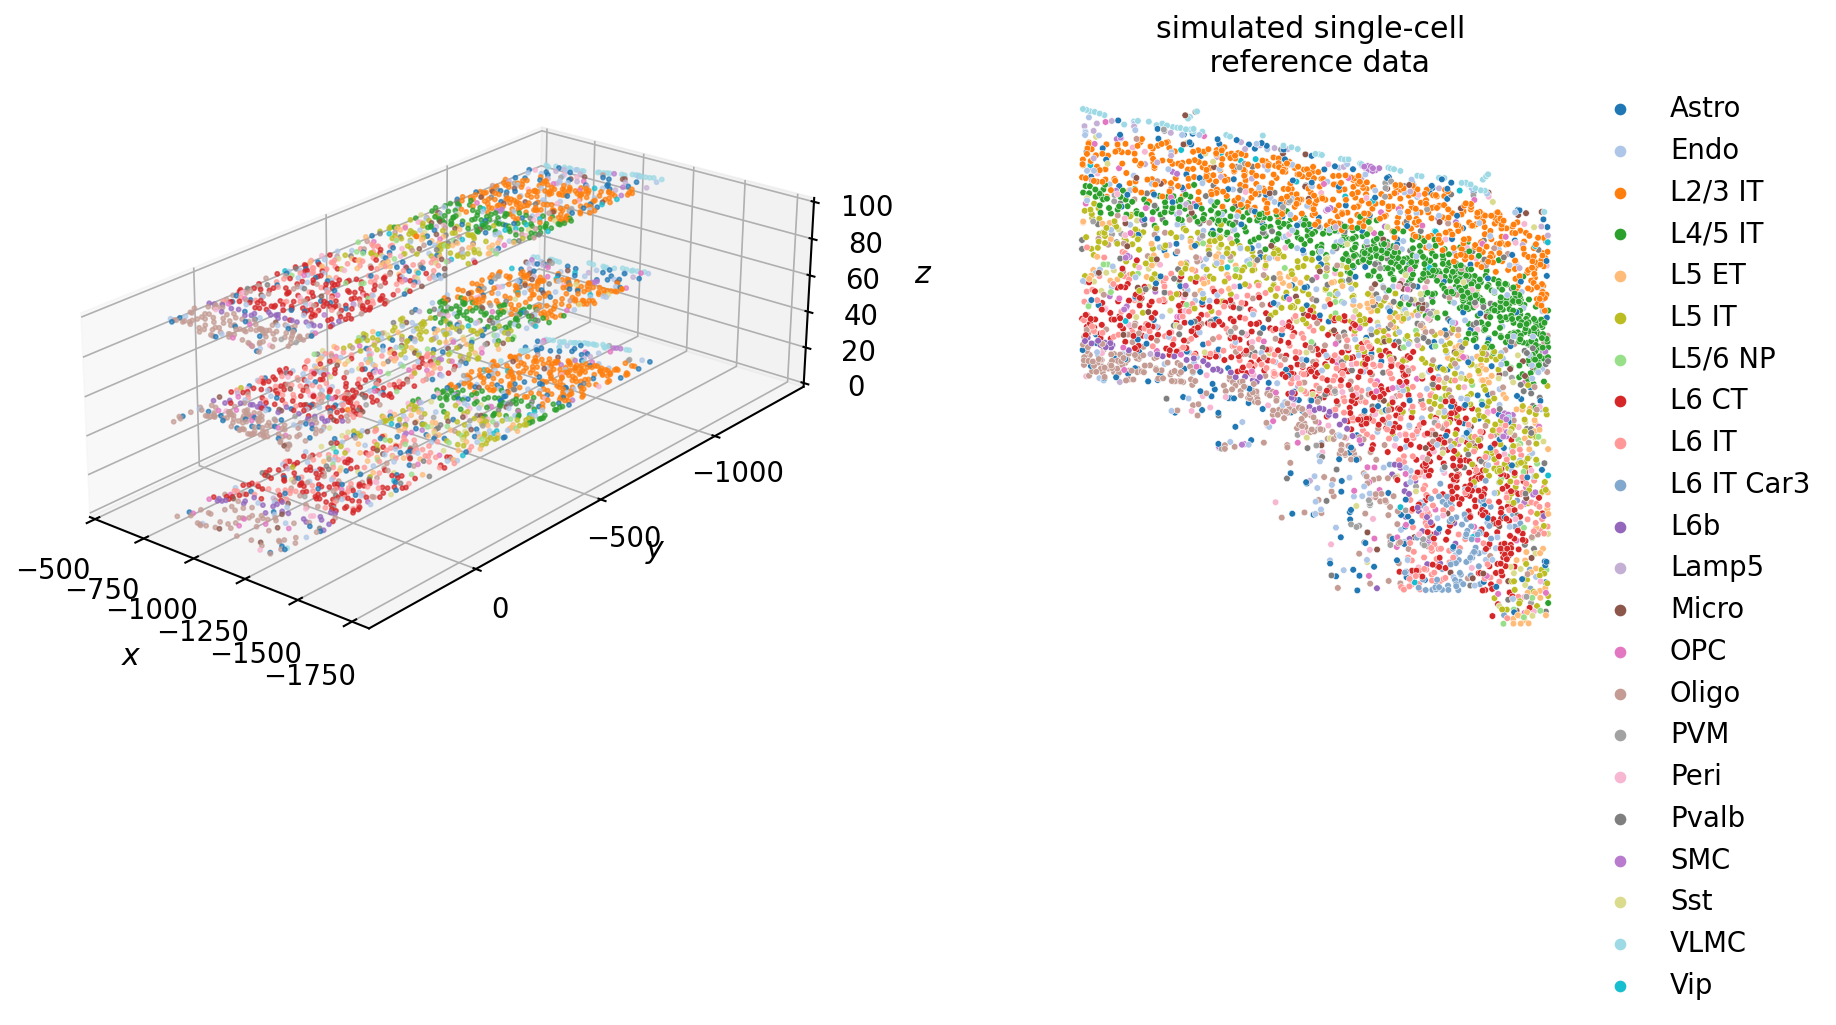

In [68]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = sp_adata.obsm['spatial_align'][:,0],\
        sp_adata.obsm['spatial_align'][:,1],\
        sp_adata.obsm['spatial_align'][:,2]

sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(15, 5),dpi = 150)
ax = plt.subplot(1,3,(1,2), projection='3d')
ax1 = plt.subplot(1,3,3)

# fig = plt.figure(figsize=(10,5),dpi=200)
# ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

ax.scatter(x, y, z, c=sp_adata.obs['subclass'].map(color_dict), s=4., alpha=0.7)
ax.set_zlim(0,100)
ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

plt.gca().invert_yaxis()


sns.scatterplot(data=sc_adata.obs, x="x", y="y", hue='subclass', s = 10, palette = color_dict, ax = ax1)
ax1.set_title('simulated single-cell \n reference data')
ax1.axis('off')
# ax1.invert_yaxis()
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)



ax.view_init(23,130)
plt.show()

In [4]:
slice1, slice2, slice3 = np.unique(sp_adata.obs['slice_id'])
print(f'sample1 name: {slice1}')
print(f'sample2 name: {slice2}')
print(f'sample2 name: {slice3}')

slice1 = sp_adata.copy()[sp_adata.obs['slice_id'] == slice1]
slice2 = sp_adata.copy()[sp_adata.obs['slice_id'] == slice2]
slice3 = sp_adata.copy()[sp_adata.obs['slice_id'] == slice3]   
    
print(f'slice1 shape: {slice1.shape}')
print(f'slice2 shape: {slice2.shape}')
print(f'slice3 shape: {slice3.shape}')

sample1 name: mouse1_slice162
sample2 name: mouse1_slice170
sample2 name: mouse1_slice180
slice1 shape: (972, 254)
slice2 shape: (950, 254)
slice3 shape: (1024, 254)


In [5]:
x_min = sp_adata.obsm['spatial_align'].copy()[:,0].min() - 1e-6
x_max = sp_adata.obsm['spatial_align'].copy()[:,0].max() + 1e-6
y_min = sp_adata.obsm['spatial_align'].copy()[:,1].min() - 1e-6
y_max = sp_adata.obsm['spatial_align'].copy()[:,1].max() + 1e-6
print((x_min, x_max), (y_min, y_max))
print(y_max - y_min, x_max - x_min, (y_max - y_min) / (x_max - x_min))

num_x = 15
num_y = 45

# make grid 
x_seg = np.linspace(x_min, x_max, num_x)
y_seg = np.linspace(y_min, y_max, num_y)

print(x_seg[1] - x_seg[0], y_seg[1] - y_seg[0])

(-1233.0309814397588, -724.5213050658245) (-1307.1003554929032, 276.9663413733067)
1584.06669686621 508.5096763739342 3.1151161334073834
36.32211974099528 36.00151583786851


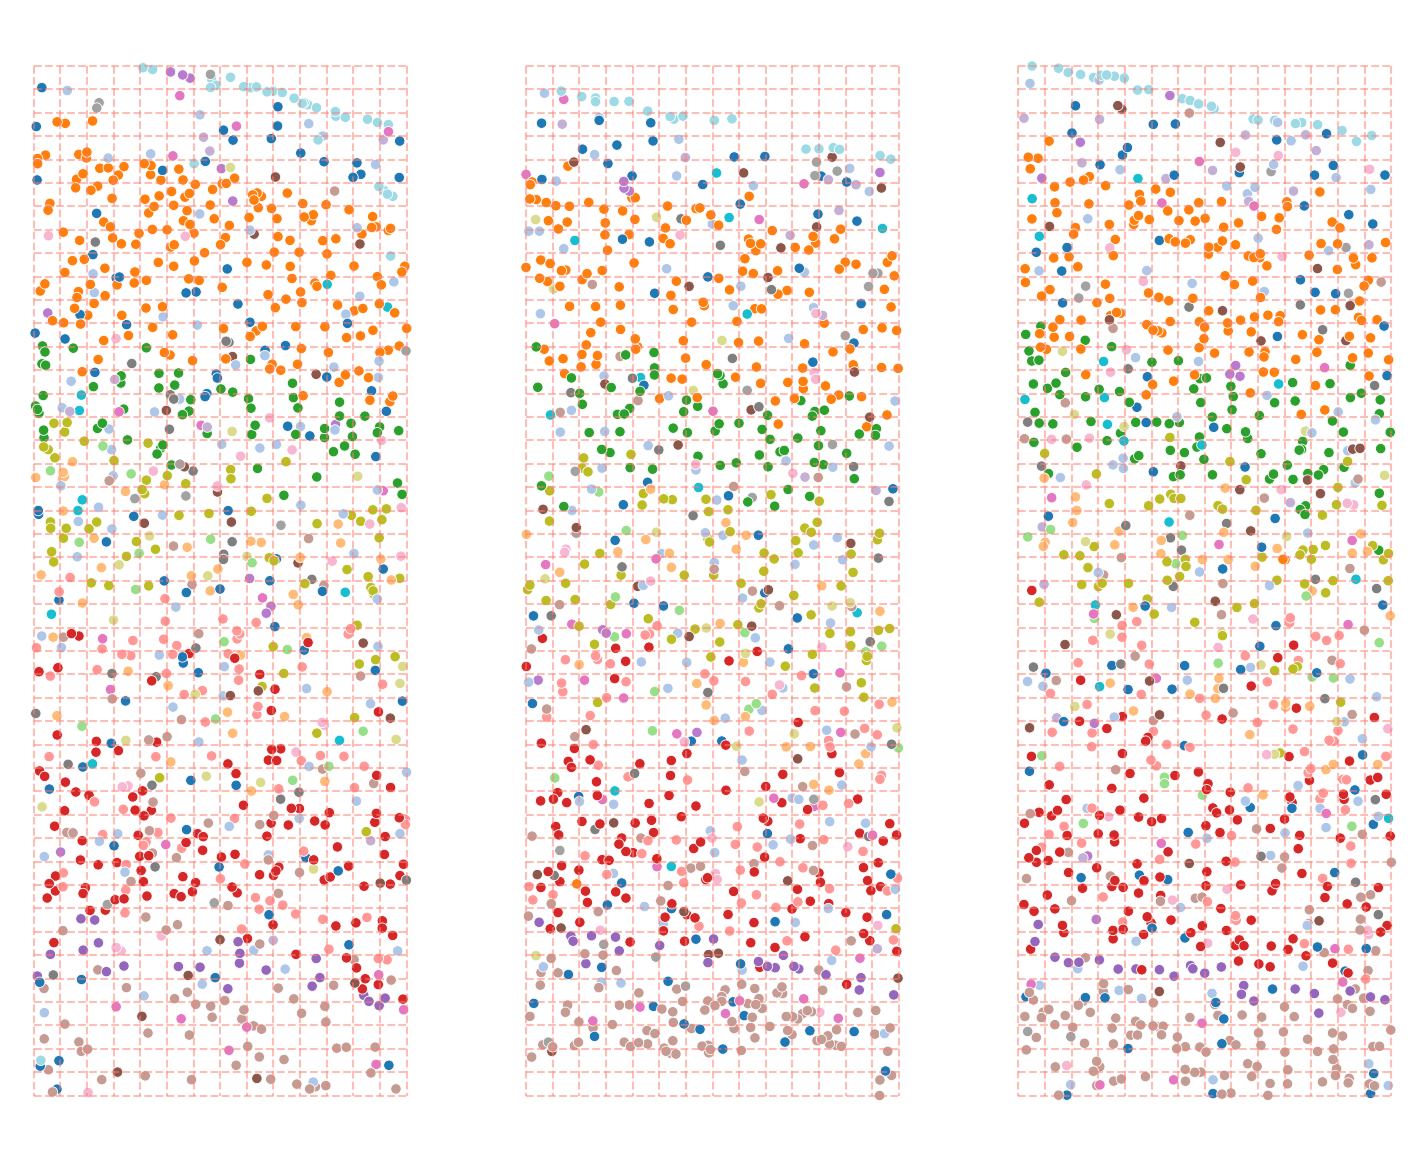

In [73]:
fig, axes = plt.subplots(1,3, figsize = (12, 10), dpi = 150)
    
sns.scatterplot(data=slice1.obs, x="x", y="y", hue=sp_cell_class_column, s = 25, palette = color_dict, legend = False, ax = axes[0])
sns.scatterplot(data=slice2.obs, x="x", y="y", hue=sp_cell_class_column, s = 25, palette = color_dict, legend = False, ax = axes[1])
sns.scatterplot(data=slice3.obs, x="x", y="y", hue=sp_cell_class_column, s = 25, palette = color_dict, legend = False, ax = axes[2])

for ax in axes:
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = 1, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = 1, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

In [6]:
mean_UMI = sp_adata.X.sum(1).mean()
print(mean_UMI)
sample_UMIs = [int(0.5 * mean_UMI), int(1.0 * mean_UMI), int(2.0 * mean_UMI)]
print(sample_UMIs)

265.97144
[132, 265, 531]


In [7]:
base_path = '/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D'
if not os.path.exists(base_path):
    os.mkdir(base_path)
base_path = os.path.join(base_path, str(num_x) + 'x' + str(num_y))
if not os.path.exists(base_path):
    os.mkdir(base_path)

for sample_UMI in sample_UMIs:
    save_data_dir = os.path.join(base_path, f'{int(sample_UMI)}UMI')
    print(save_data_dir)
    if not os.path.exists(save_data_dir):
        os.mkdir(save_data_dir)

/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/132UMI
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/531UMI


# SpatialScope 3D
```
#!/bin/bash 

set -o pipefail
set -exu

for rep in {0..9}

do 

for i in 0 0.000001 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column subclass \
--tissue "rep$rep" \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/spatial.h5ad \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--find_neighbor_radius 53 \
--nu $i

done

done

for rep in {3..9}
do
mkdir /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/3D_single/rep$rep
cp /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/rep$rep/InitProp.pickle /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/3D_single/rep$rep
done
```

# StarDist + RCTD 

```
for rep in {0..9}

do 

python ./compared_methods/SDRCTD.py \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/rep$rep \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/spatial.h5ad \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--cell_class_column subclass \
--cell_num_column cell_nums \
--hs_ST \

done
```
# SpatialScope 2D

```
for rep in {0..9}

do 

for i in 0 0.000001 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column subclass \
--tissue "rep$rep" \
--out_dir /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/3D_single \
--ST_Data /home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/3D_single/spatial.h5ad \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--find_neighbor_radius 53 \
--nu $i

done
done
```

In [8]:
DataDir = os.path.join(base_path, str(sample_UMIs[1]) + 'UMI')
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))

In [9]:
sp_adata

AnnData object with n_obs × n_vars = 1521 × 254
    obs: 'x', 'y', 'cell_nums', 'z', 'batch', 'sample'
    uns: 'cell_locations'
    obsm: 'spatial'

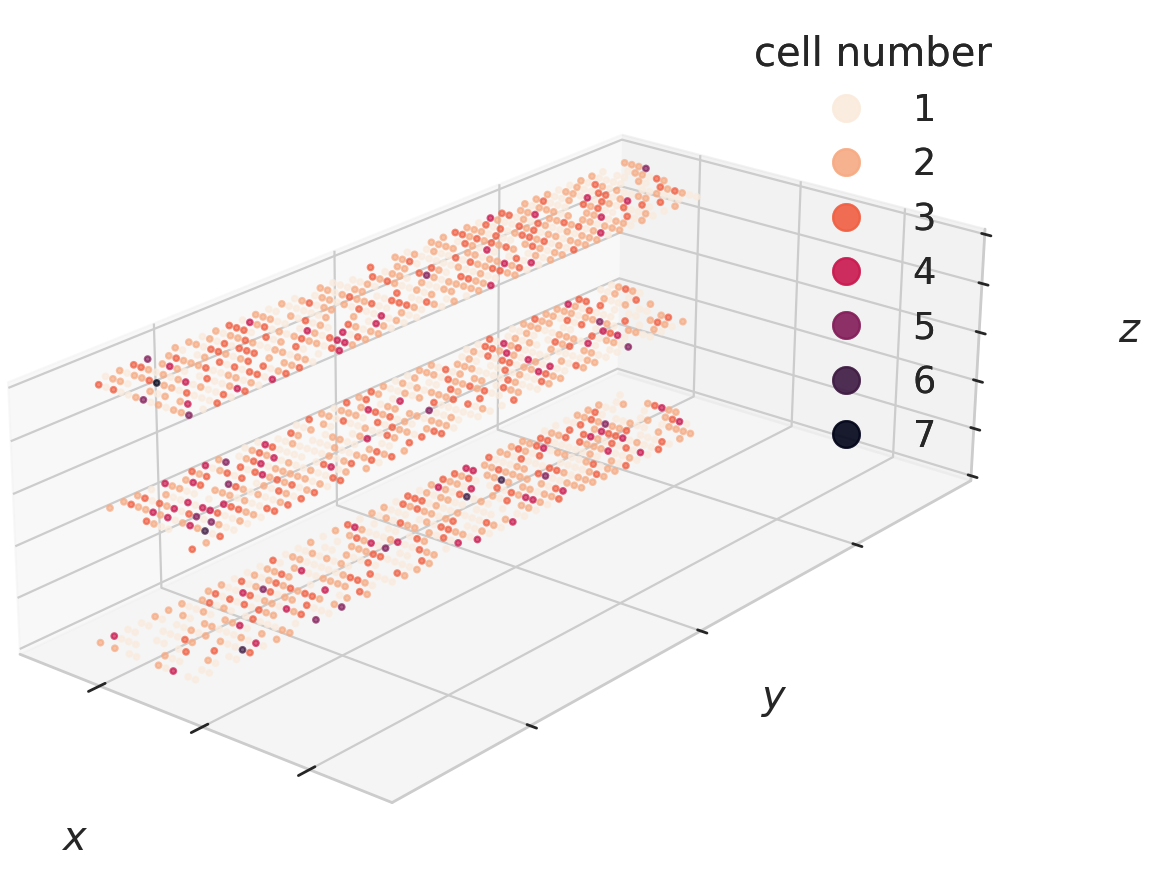

In [349]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = sp_adata.obsm['spatial'][:,0],\
        sp_adata.obsm['spatial'][:,1],\
        sp_adata.obsm['spatial'][:,2]*50 / 3

sns.set_context('paper',font_scale=1.5)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

scatter = ax.scatter(x, y, z, c=np.array(sp_adata.obs['cell_nums']), s=4., alpha=0.7, cmap = sns.color_palette("rocket_r", as_cmap=True))
ax.set_zlim(0,100)
# ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()

legend1 = ax.legend(*scatter.legend_elements(prop = 'colors'), title="cell number", bbox_to_anchor=(1.3,1.1), markerscale = 2)
ax.add_artist(legend1)


ax.view_init(23,130)
plt.show()

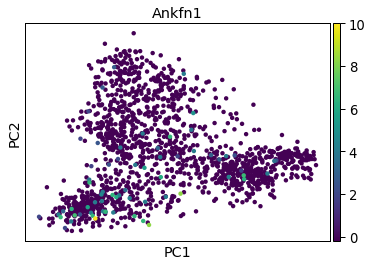

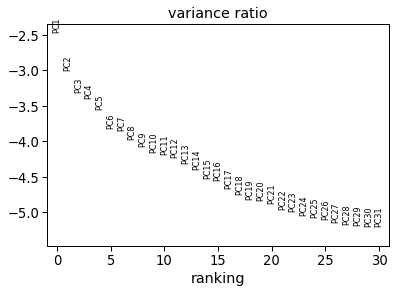

In [94]:
leiden_sp = sp_adata.copy()

sc.pp.log1p(leiden_sp)
sc.pp.scale(leiden_sp, max_value=10)
sc.tl.pca(leiden_sp, svd_solver='arpack')
sc.pl.pca(leiden_sp, color=sp_adata.var.index[10])
sc.pl.pca_variance_ratio(leiden_sp, log=True)
sc.pp.neighbors(leiden_sp, n_neighbors=10, n_pcs=40)
sc.tl.leiden(leiden_sp)

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('default')

sns.set_context('paper',font_scale=1.6) 

# with mpl.rc_context({'figure.figsize': (9, 9), 'figure.dpi': 150}):
#     ax = sns.scatterplot(data=leiden_sp.obs, x="x", y="y", hue='leiden', s = 110, palette = 'tab20')
# #     ax = sns.scatterplot(data=sp_adata.obs, x="X", y="Y", s = 50, palette = "rocket_r")
#     ax.invert_yaxis()
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     plt.legend(bbox_to_anchor=(1,0.6), title = 'cell number', markerscale = 3)

In [95]:
leiden_sp

AnnData object with n_obs × n_vars = 1521 × 254
    obs: 'x', 'y', 'cell_nums', 'z', 'batch', 'sample', 'leiden'
    var: 'mean', 'std'
    uns: 'cell_locations', 'log1p', 'pca', 'neighbors', 'leiden'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [103]:
np.unique(np.array(leiden_sp.obs['leiden']).astype(np.int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

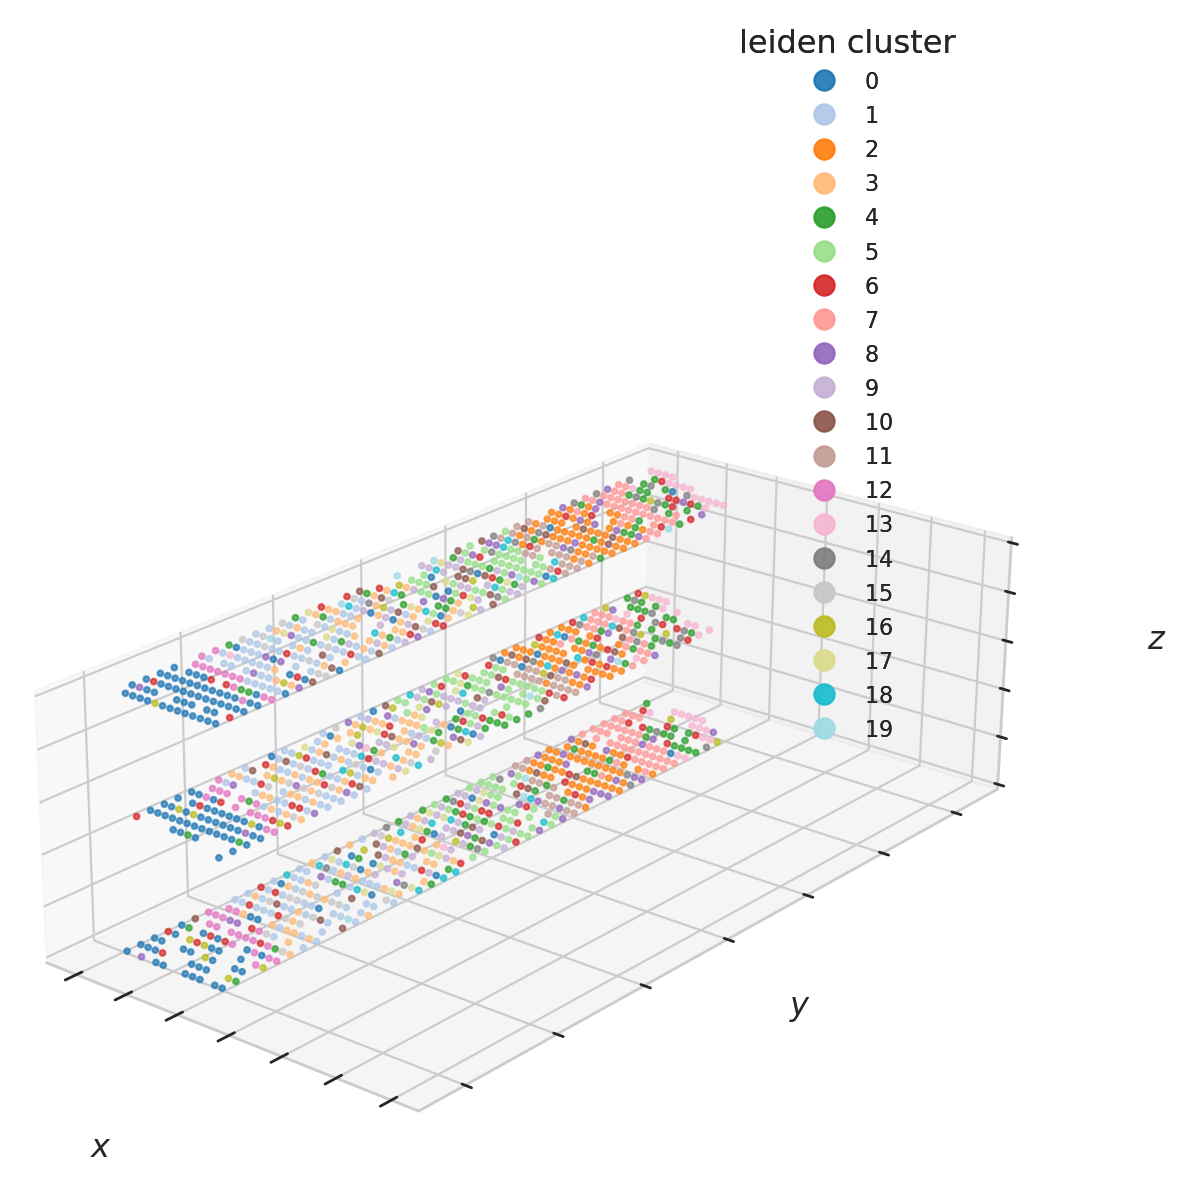

In [340]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = leiden_sp.obsm['spatial'][:,0],\
        leiden_sp.obsm['spatial'][:,1],\
        leiden_sp.obsm['spatial'][:,2]*2.5

sns.set_context('paper',font_scale=1.2)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

scatter = ax.scatter(x, y, z, c=np.array(leiden_sp.obs['leiden']).astype(np.int), s=4., alpha=0.7, cmap = sns.color_palette("tab20", as_cmap=True))
ax.set_zlim(0,100)
# ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xticklabels('')
# ax.set_xticks([])
ax.set_yticklabels('')
# ax.set_yticks([])
ax.set_zticklabels('')
# ax.set_zticks([])

plt.gca().invert_yaxis()

legend1 = ax.legend(*scatter.legend_elements(prop = 'colors', num = 20),
                    loc="upper right", title="leiden cluster", bbox_to_anchor=(1.2,1.5), markerscale = 1.5, fontsize = 8)
ax.add_artist(legend1)


ax.view_init(23,130)
plt.show()

## nu test

In [10]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df


In [11]:
DataDir

'/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI'

In [12]:
def label_to_matrix(spot_label, label):
    matrix = pd.DataFrame(index = np.unique(spot_label), columns = np.unique(np.array(label)))
    for i in np.unique(spot_label):
        each_spot_prop_df = pd.DataFrame(index = np.unique(np.array(label)))
        each_spot_prop_df['prop'] = np.zeros(each_spot_prop_df.shape[0])
        index = spot_label == i
        val, counts = np.unique(label[index], return_counts=True)
        each_spot_prop_df.loc[val, 'prop'] = counts
        matrix.loc[i,:] = each_spot_prop_df.values.squeeze()

    return matrix

gd_results = label_to_matrix(np.array(sp_adata.uns['cell_locations']['spot_index_int']), np.array(sp_adata.uns['cell_locations'][sp_cell_class_column]))
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)

## deconvolution

In [218]:
# neighbor_range = 'n_neighbo_20'
neighbor_range = ''

In [ ]:
nu_list = [0, 0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
# nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', '3D', 'rep'})
decon_df = pd.DataFrame()
decon_pcc_df = pd.DataFrame()
decon_rmse_df = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        ################################################################################################################## RCTD resutls
        with open(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
            
        ################################################################################################################## StarDist + RCTD resutls
        SR_results = sc.read(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]
        ################################################################################################################## SpatialScope_3D resuslts
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_results = prop
        SpatialScope_results.index = np.arange(len(RCTD_results))
        SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
   ################################################################################################################## SpatialScope resuslts     
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_3D_single_results = prop
        SpatialScope_3D_single_results.index = np.arange(len(SpatialScope_3D_single_results))
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,np.unique(SpatialScope_3D_single_results.columns)]

    ##################################################################################################################  
        RCTD_results = RCTD_results.loc[:,gd_results.columns]
        SR_results = SR_results.loc[:,gd_results.columns]
        SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,gd_results.columns]  


        starmap_spots_pcc = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='pcc'
        )

        starmap_spots_rmse = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='rmse'
        )

        starmap_spots_pcc['nu'] = [nu] * starmap_spots_pcc.shape[0]
        starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
        starmap_spots_rmse['nu'] = [nu] * starmap_spots_rmse.shape[0]
        starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]

        starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

        decon_df = pd.concat([decon_df, starmap_spots_pcc, starmap_spots_rmse], axis = 0)
        decon_pcc_df = pd.concat([decon_pcc_df, starmap_spots_pcc], axis = 0)
        decon_rmse_df = pd.concat([decon_rmse_df, starmap_spots_rmse], axis = 0)


        

nu = 0; rep = 0
nu = 0; rep = 1
nu = 0; rep = 2
nu = 0; rep = 3
nu = 0; rep = 4
nu = 0; rep = 5
nu = 0; rep = 6
nu = 0; rep = 7
nu = 0; rep = 8
nu = 0; rep = 9
nu = 1e-06; rep = 0
nu = 1e-06; rep = 1
nu = 1e-06; rep = 2
nu = 1e-06; rep = 3
nu = 1e-06; rep = 4
nu = 1e-06; rep = 5
nu = 1e-06; rep = 6
nu = 1e-06; rep = 7
nu = 1e-06; rep = 8
nu = 1e-06; rep = 9
nu = 5; rep = 0
nu = 5; rep = 1
nu = 5; rep = 2
nu = 5; rep = 3
nu = 5; rep = 4
nu = 5; rep = 5
nu = 5; rep = 6
nu = 5; rep = 7
nu = 5; rep = 8
nu = 5; rep = 9
nu = 10; rep = 0
nu = 10; rep = 1
nu = 10; rep = 2
nu = 10; rep = 3
nu = 10; rep = 4
nu = 10; rep = 5
nu = 10; rep = 6
nu = 10; rep = 7
nu = 10; rep = 8
nu = 10; rep = 9
nu = 20; rep = 0
nu = 20; rep = 1
nu = 20; rep = 2
nu = 20; rep = 3
nu = 20; rep = 4
nu = 20; rep = 5
nu = 20; rep = 6
nu = 20; rep = 7
nu = 20; rep = 8
nu = 20; rep = 9
nu = 30; rep = 0
nu = 30; rep = 1
nu = 30; rep = 2
nu = 30; rep = 3
nu = 30; rep = 4
nu = 30; rep = 5
nu = 30; rep = 6
nu = 30; rep = 7
nu =

In [263]:
decon_df.to_csv(os.path.join(DataDir, 'decon_df.csv'))

In [19]:
decon_df = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)

In [20]:
decon_df

RCTD        SR  SpatialScope  SpatialScope_3D      nu metric  \
0     0.999905  1.000000      1.000000         1.000000     0.0    pcc   
1     0.711550  0.447368      0.689202         0.689202     0.0    pcc   
2     0.983854  1.000000      1.000000         1.000000     0.0    pcc   
3     0.964366  1.000000      1.000000         1.000000     0.0    pcc   
4     0.997091  1.000000      1.000000         1.000000     0.0    pcc   
...        ...       ...           ...              ...     ...    ...   
1516  0.084098  0.102869      0.102869         0.102869  1000.0   rmse   
1517  0.031959  0.000000      0.000000         0.000000  1000.0   rmse   
1518  0.001628  0.000000      0.000000         0.000000  1000.0   rmse   
1519  0.118869  0.000000      0.308607         0.308607  1000.0   rmse   
1520  0.083433  0.061721      0.123443         0.123443  1000.0   rmse   

      cell_nums  
0             1  
1             2  
2             2  
3             2  
4             1  
...         ...  
1516          3  
1517          1  
1518          3  
1519          1  
1520          5  

[547560 rows x 7 columns]

# add nv = 0

In [155]:
# nu_list = [0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
nu_list = [0]

decon_df = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)
decon_pcc_df = pd.DataFrame()
decon_rmse_df = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        ################################################################################################################## RCTD resutls
        with open(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
        ################################################################################################################## StarDist + RCTD resutls
        SR_results = sc.read(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]
    ################################################################################################################## SpatialScope_3D resuslts
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_results = prop
        SpatialScope_results.index = np.arange(len(RCTD_results))
        SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
        print(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))
        SpatialScope_results.to_csv(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))  


   ################################################################################################################## SpatialScope resuslts     
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_3D_single_results = prop
        SpatialScope_3D_single_results.index = np.arange(len(SpatialScope_3D_single_results))
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,np.unique(SpatialScope_3D_single_results.columns)]

    ##################################################################################################################  
        RCTD_results = RCTD_results.loc[:,gd_results.columns]
        SR_results = SR_results.loc[:,gd_results.columns]
        SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]
        SpatialScope_3D_single_results = SpatialScope_3D_single_results.loc[:,gd_results.columns]  


        starmap_spots_pcc = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='pcc'
        )

        starmap_spots_rmse = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_3D_single_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope', 'SpatialScope_3D'],
            axis=0,
            metric='rmse'
        )

        starmap_spots_pcc['nu'] = [int(nu)] * starmap_spots_pcc.shape[0]
        starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
        starmap_spots_rmse['nu'] = [int(nu)] * starmap_spots_rmse.shape[0]
        starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]

        starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

        decon_df = pd.concat([decon_df, starmap_spots_pcc, starmap_spots_rmse], axis = 0)
        decon_pcc_df = pd.concat([decon_pcc_df, starmap_spots_pcc], axis = 0)
        decon_rmse_df = pd.concat([decon_rmse_df, starmap_spots_rmse], axis = 0)


        

nu = 0; rep = 0
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep0/SpatialScope_result_nu0.txt
nu = 0; rep = 1
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep1/SpatialScope_result_nu0.txt
nu = 0; rep = 2
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep2/SpatialScope_result_nu0.txt
nu = 0; rep = 3
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep3/SpatialScope_result_nu0.txt
nu = 0; rep = 4
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep4/SpatialScope_result_nu0.txt
nu = 0; rep = 5
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep5/SpatialScope_result_nu0.txt
nu = 0; rep = 6
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/rep6/SpatialScope_result_nu0.txt
nu = 0; rep = 7
/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI/n_neighbo_20/r

In [368]:
decon_df

RCTD        SR  SpatialScope  SpatialScope_3D      nu metric  \
0     0.999905  1.000000      1.000000         1.000000     0.0    pcc   
1     0.711550  0.447368      0.689202         0.689202     0.0    pcc   
2     0.983854  1.000000      1.000000         1.000000     0.0    pcc   
3     0.964366  1.000000      1.000000         1.000000     0.0    pcc   
4     0.997091  1.000000      1.000000         1.000000     0.0    pcc   
...        ...       ...           ...              ...     ...    ...   
1516  0.084098  0.102869      0.102869         0.102869  1000.0   rmse   
1517  0.031959  0.000000      0.000000         0.000000  1000.0   rmse   
1518  0.001628  0.000000      0.000000         0.000000  1000.0   rmse   
1519  0.118869  0.000000      0.308607         0.308607  1000.0   rmse   
1520  0.083433  0.061721      0.123443         0.123443  1000.0   rmse   

      cell_nums  
0             1  
1             2  
2             2  
3             2  
4             1  
...         ...  
1516          3  
1517          1  
1518          3  
1519          1  
1520          5  

[547560 rows x 7 columns]

In [166]:
decon_df = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)
decon_df_addnv0 = pd.read_csv(os.path.join(DataDir, 'decon_df_addnv0.csv'), index_col = 0)

decon_df.loc[decon_df['nu'] == 0, 'nu'] = 1e-6
decon_df = pd.concat([decon_df, decon_df_addnv0.iloc[decon_df.shape[0]:, :]], axis = 0)

In [167]:
decon_df

RCTD        SR  SpatialScope  SpatialScope_3D        nu metric  \
0     0.999905  1.000000      1.000000         1.000000  0.000001    pcc   
1     0.711550  0.447368      0.689202         0.689202  0.000001    pcc   
2     0.983854  1.000000      1.000000         1.000000  0.000001    pcc   
3     0.964366  1.000000      1.000000         1.000000  0.000001    pcc   
4     0.997091  1.000000      1.000000         1.000000  0.000001    pcc   
...        ...       ...           ...              ...       ...    ...   
1516  0.084098  0.102869      0.102869         0.102869  0.000000   rmse   
1517  0.031959  0.000000      0.000000         0.000000  0.000000   rmse   
1518  0.001628  0.000000      0.000000         0.000000  0.000000   rmse   
1519  0.118869  0.000000      0.308607         0.308607  0.000000   rmse   
1520  0.083433  0.061721      0.061721         0.061721  0.000000   rmse   

      cell_nums  
0             1  
1             2  
2             2  
3             2  
4             1  
...         ...  
1516          3  
1517          1  
1518          3  
1519          1  
1520          5  

[547560 rows x 7 columns]

# error rate

In [269]:
neighbor_range

''

In [289]:
# nu_list = [0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
# nu_list = [0, 0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', '3D', 'rep'})

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
            
        ################################################################################################################## StarDist + RCTD resutls
        if nu == 'RCTD':  
            SR_results = sc.read(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
            SR_cell_type_label = SR_results.uns['cell_locations'].copy()
#             SR_cell_type_label = shuffle_cell_type_per_spot(SR_cell_type_label, 'SDRCTD_cell_type', sp_adata.shape[0])
            
#             SR_cell_type_label = SR_cell_type_label[SR_cell_type_label.cell_nums == 1]
        
            estimated = np.array(SR_cell_type_label['SDRCTD_cell_type'])
            tl = np.array(SR_cell_type_label[sp_cell_class_column])
            error_index = tl != estimated
            SR_cell_type_label['error'] = (error_index).astype(int) 
            RCTD_error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': RCTD_error_rate, 'nu': nu, '3D': False, 'rep': int(rep)}
        
        ################################################################################################################## StarDist + RCTD error rate
        else:
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

#             cell_locations = cell_locations[cell_locations.cell_nums == 1]
            
            estimated = np.array(cell_locations['discrete_label_ct'])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            if isinstance(nu, int):
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), '3D': True, 'rep': int(rep)}
            else:
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': nu, '3D': True, 'rep': int(rep)}    
                
            ####################################################################################################################################
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', neighbor_range, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

#             cell_locations = cell_locations[cell_locations.cell_nums == 1]
            
            estimated = np.array(cell_locations['discrete_label_ct'])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            if isinstance(nu, int):
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), '3D': False, 'rep': int(rep)}
            else:
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': nu, '3D': False, 'rep': int(rep)}      
        

nu = 0; rep = 0
nu = 0; rep = 1
nu = 0; rep = 2
nu = 0; rep = 3
nu = 0; rep = 4
nu = 0; rep = 5
nu = 0; rep = 6
nu = 0; rep = 7
nu = 0; rep = 8
nu = 0; rep = 9
nu = 5; rep = 0
nu = 5; rep = 1
nu = 5; rep = 2
nu = 5; rep = 3
nu = 5; rep = 4
nu = 5; rep = 5
nu = 5; rep = 6
nu = 5; rep = 7
nu = 5; rep = 8
nu = 5; rep = 9
nu = 10; rep = 0
nu = 10; rep = 1
nu = 10; rep = 2
nu = 10; rep = 3
nu = 10; rep = 4
nu = 10; rep = 5
nu = 10; rep = 6
nu = 10; rep = 7
nu = 10; rep = 8
nu = 10; rep = 9
nu = 20; rep = 0
nu = 20; rep = 1
nu = 20; rep = 2
nu = 20; rep = 3
nu = 20; rep = 4
nu = 20; rep = 5
nu = 20; rep = 6
nu = 20; rep = 7
nu = 20; rep = 8
nu = 20; rep = 9
nu = 30; rep = 0
nu = 30; rep = 1
nu = 30; rep = 2
nu = 30; rep = 3
nu = 30; rep = 4
nu = 30; rep = 5
nu = 30; rep = 6
nu = 30; rep = 7
nu = 30; rep = 8
nu = 30; rep = 9
nu = 40; rep = 0
nu = 40; rep = 1
nu = 40; rep = 2
nu = 40; rep = 3
nu = 40; rep = 4
nu = 40; rep = 5
nu = 40; rep = 6
nu = 40; rep = 7
nu = 40; rep = 8
nu = 40; rep = 9


In [290]:
error_rate_df.to_csv(os.path.join(DataDir, 'error_rate_df.csv'))

In [291]:
error_rate_df = pd.read_csv(os.path.join(DataDir, 'error_rate_df.csv'), index_col = 0)

In [292]:
error_rate_df

rep    nu     3D  error_rate
0      0     0   True    0.353700
1      0     0  False    0.352342
2      1     0   True    0.358452
3      1     0  False    0.354039
4      2     0   True    0.352682
..   ...   ...    ...         ...
345    5  RCTD  False    0.339443
346    6  RCTD  False    0.340462
347    7  RCTD  False    0.341141
348    8  RCTD  False    0.346232
349    9  RCTD  False    0.348269

[350 rows x 4 columns]

## error rate 

In [293]:
vis_nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['StarDist \n + RCTD']

In [355]:
temp_df = error_rate_df.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D')
temp_df.iloc[:,:-1] =  temp_df.iloc[:,:-1].loc[:,np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(int).astype(str)]
temp_df.columns = vis_nu_list[:-1] + ['RCTD']
temp_df

0        5       10        20        30        40        50  \
3D                                                                          
False  0.354345  0.34002  0.33795  0.334420  0.338086  0.337644  0.341107   
True   0.354854  0.32203  0.32186  0.319756  0.323489  0.328140  0.330957   

             60        70        80        90       100       120       150  \
3D                                                                            
False  0.340224  0.343415  0.344739  0.345689  0.347963  0.350950  0.352071   
True   0.335743  0.337610  0.337916  0.341174  0.343177  0.343517  0.347963   

            200       500      1000      RCTD  
3D                                             
False  0.356517  0.360591  0.422912  0.342668  
True   0.349423  0.363714  0.441344       NaN

In [356]:
temp_df_sd = error_rate_df.copy().pivot_table(values = 'error_rate', columns = 'nu', index = '3D', aggfunc = np.std)
temp_df_sd.iloc[:,:-1] =  temp_df_sd.iloc[:,:-1].loc[:,np.array([0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000]).astype(int).astype(str)]
temp_df_sd.columns = vis_nu_list[:-1] + ['RCTD']
temp_df_sd

0         5        10        20        30      40        50  \
3D                                                                          
False  0.001513  0.001832  0.004033  0.003401  0.002762  0.0022  0.001771   
True   0.001710  0.002352  0.002839  0.002373  0.002379  0.0013  0.001731   

             60        70        80        90       100       120       150  \
3D                                                                            
False  0.001609  0.002330  0.002454  0.002576  0.001969  0.001125  0.001865   
True   0.001635  0.002938  0.002190  0.003017  0.001953  0.001866  0.002197   

            200       500      1000      RCTD  
3D                                             
False  0.001648  0.001368  0.004256  0.005218  
True   0.001812  0.001100  0.001420       NaN

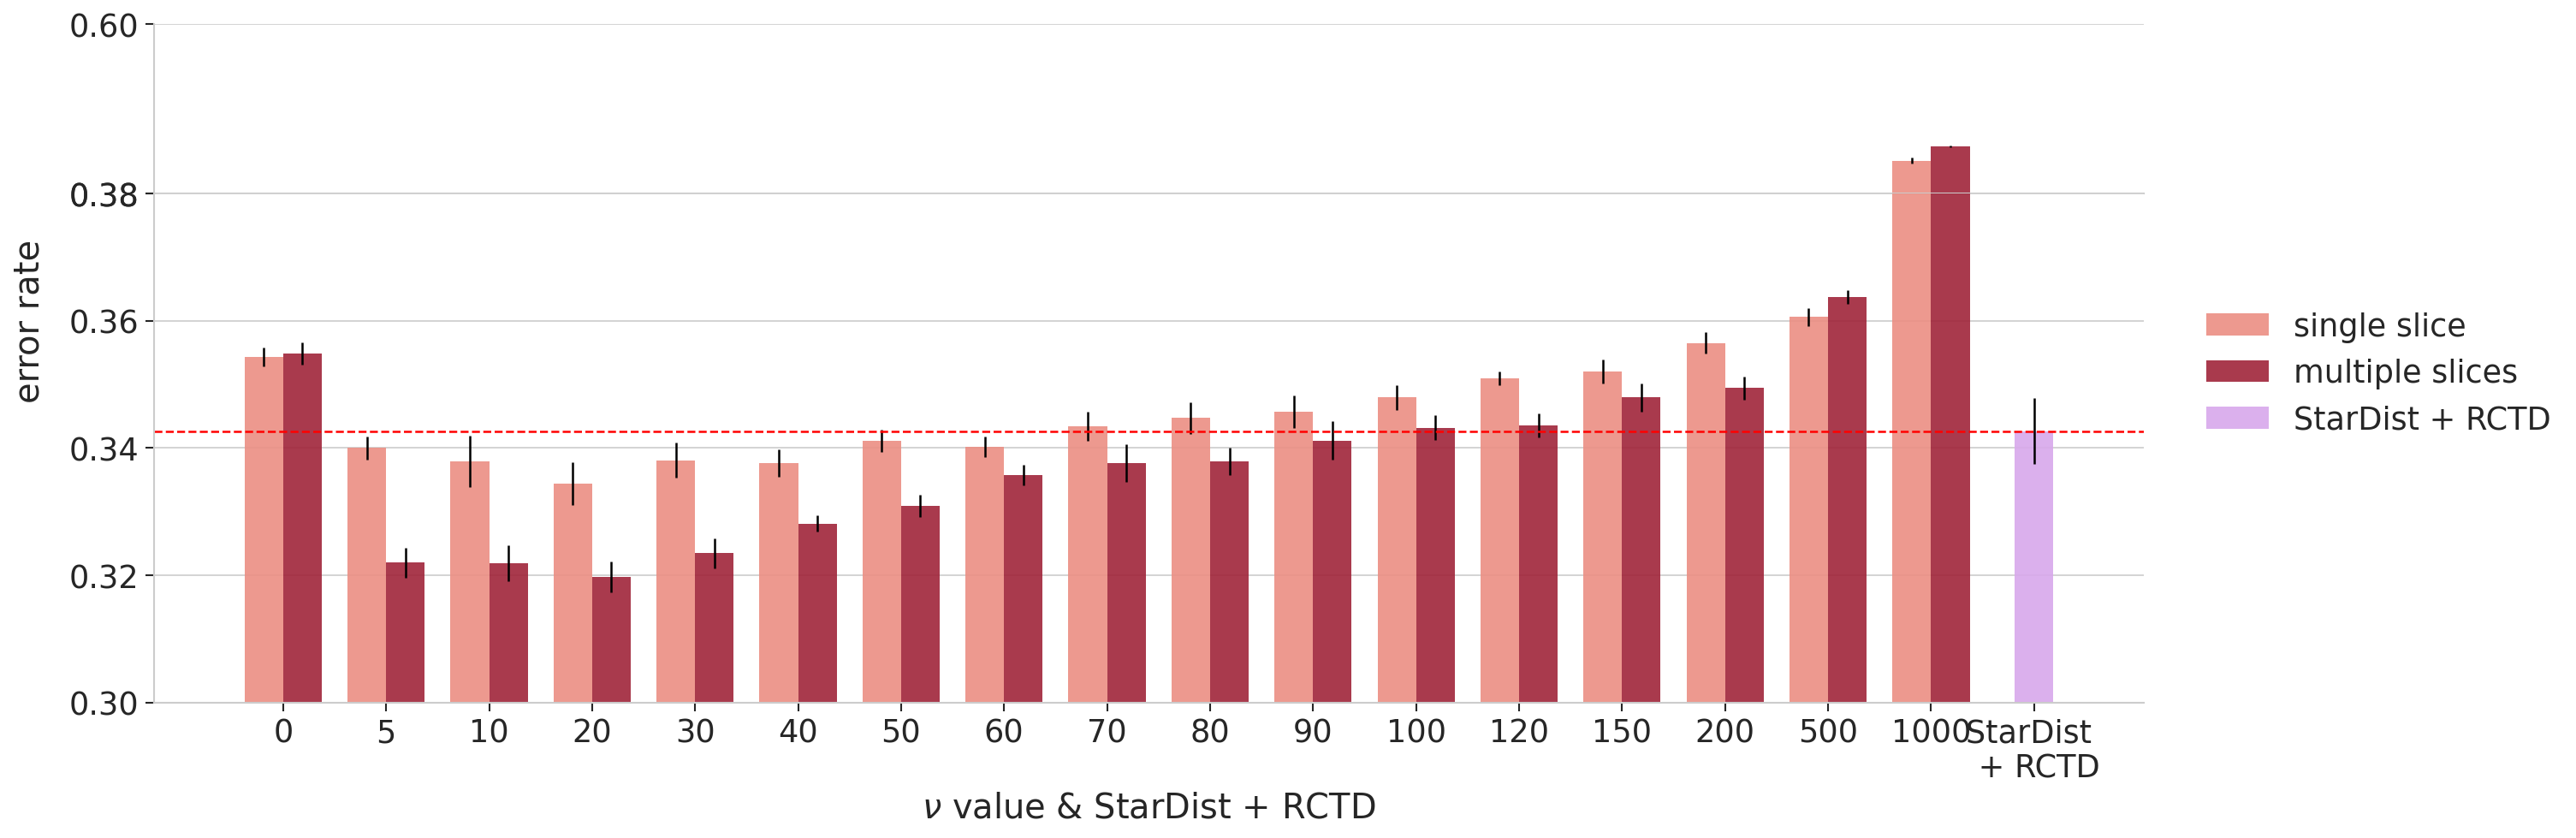

In [366]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid') # seaborn-whitegrid

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(2,1, figsize = (20, 7), dpi = 150, gridspec_kw={'height_ratios': [1, 3]})

starting_point = 0
bar_width = 3 #1.5
width_between_bar = 2 #1
order = ['single slice', 'multiple slices']
hue_len = len(order) 
dist = bar_width * hue_len + width_between_bar
    
palette = ['#EB8E83', '#A02439'] #* (len(vis_nu_list) - 1) + ['#D8A8EB']
# with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[0])
    
for j, dim in enumerate(order):
    value = temp_df.iloc[j,:-1].values
    yerr = temp_df_sd.iloc[j,:-1].values
    ax[0].bar(np.arange(starting_point,starting_point + dist * (len(vis_nu_list) - 1), dist) + bar_width * j, value, width = bar_width, yerr = yerr, alpha=.9, color = palette[j], label = dim)
    ax[0].bar(starting_point + dist * (len(vis_nu_list) - 1) + bar_width / 2, temp_df.iloc[0,-1].item(), width = bar_width, yerr = temp_df_sd.iloc[0,-1].item(), alpha=.9, color = '#D8A8EB', label = 'StarDist + RCTD')

for j, dim in enumerate(order):
    value = temp_df.iloc[j,:-1].values
    yerr = temp_df_sd.iloc[j,:-1].values
    ax[1].bar(np.arange(starting_point,starting_point + dist * (len(vis_nu_list) - 1), dist) + bar_width * j, value, width = bar_width, yerr = yerr, alpha=.9, color = palette[j], label = dim)

ax[1].bar(starting_point + dist * (len(vis_nu_list) - 1) + bar_width / 2, temp_df.iloc[0,-1].item(), width = bar_width, yerr = temp_df_sd.iloc[0,-1].item(), alpha=.9, color = '#D8A8EB', label = 'StarDist + RCTD')

    
    
    
ax[0].set_ylim(0.38, 0.6)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_yticks([0.38, 0.6])
# ax[0].set_xticks([])

# with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[1])
ax[1].set_ylim(0.30,0.38)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_yticks([0.30, 0.32, 0.34, 0.36, 0.38])

ax[0].set_ylabel("")
ax[1].set_ylabel("")


ax[0].xaxis.tick_top()
ax[1].xaxis.tick_bottom()

ax[1].legend(loc=(1.025, 0.5))
# ax[1].get_legend().remove()

fig.text(0.07, 0.55, "error rate", va="center", rotation="vertical")
ax[1].set_xticks(np.arange(starting_point,starting_point + dist * len(vis_nu_list), dist) + bar_width * (hue_len / 2 - 0.5))
ax[1].xaxis.grid()
ax[1].set_xticklabels(vis_nu_list)


plt.xlabel(r'$\nu$ value & StarDist + RCTD')
ax[1].axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.subplots_adjust(hspace = 0.0)
plt.show()

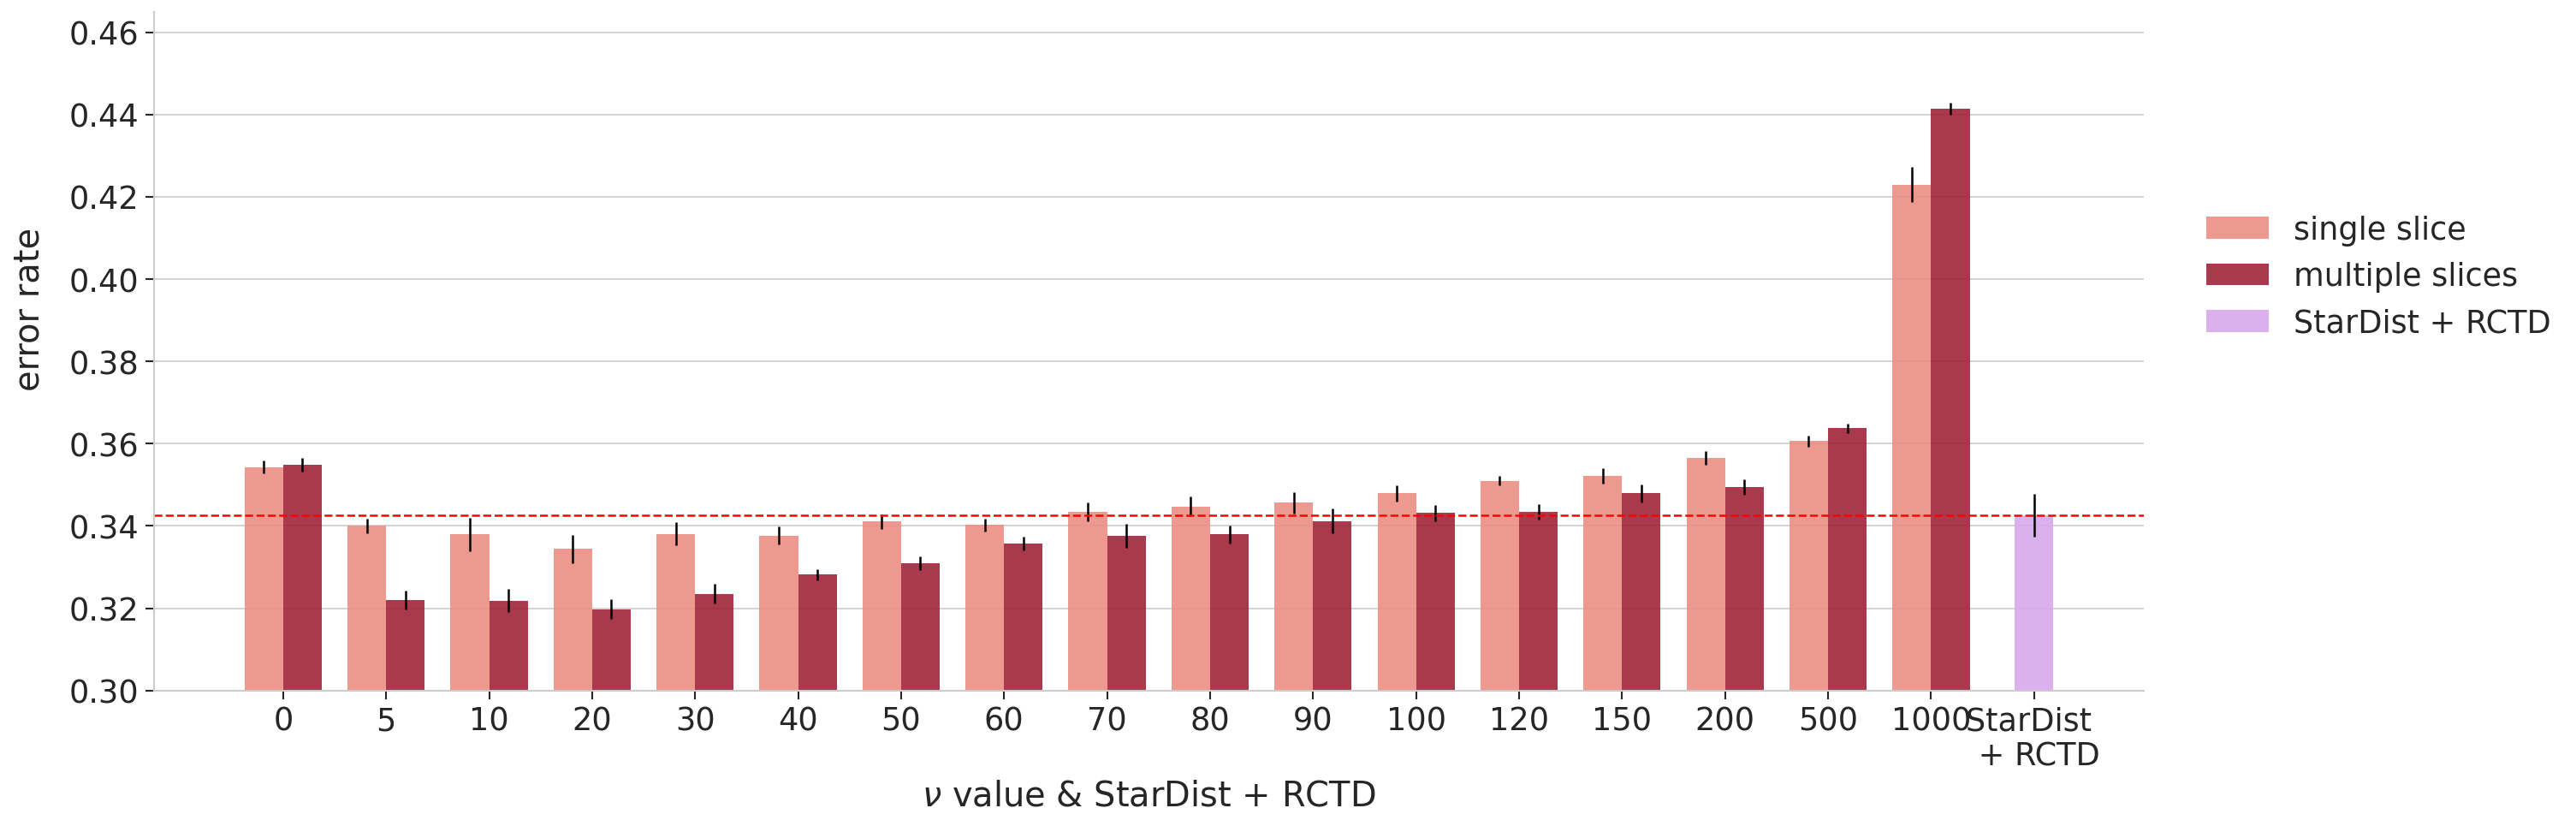

In [363]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid') # seaborn-whitegrid

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)


starting_point = 0
bar_width = 3 #1.5
width_between_bar = 2 #1
order = ['single slice', 'multiple slices']
hue_len = len(order) 
dist = bar_width * hue_len + width_between_bar
    
palette = ['#EB8E83', '#A02439'] #* (len(vis_nu_list) - 1) + ['#D8A8EB']
# with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[0])
    
for j, dim in enumerate(order):
    value = temp_df.iloc[j,:-1].values
    yerr = temp_df_sd.iloc[j,:-1].values
    ax.bar(np.arange(starting_point,starting_point + dist * (len(vis_nu_list) - 1), dist) + bar_width * j, value, width = bar_width, yerr = yerr, alpha=.9, color = palette[j], label = dim)
ax.bar(starting_point + dist * (len(vis_nu_list) - 1) + bar_width / 2, temp_df.iloc[0,-1].item(), width = bar_width, yerr = temp_df_sd.iloc[0,-1].item(), alpha=.9, color = '#D8A8EB', label = 'StarDist + RCTD')

    
ax.set_ylim(0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# ax[0].set_ylim(0.37,1.02)
# ax[0].spines['right'].set_visible(False)
# ax[0].spines['top'].set_visible(False)
# ax[0].get_xaxis().set_visible(False)
# ax[0].set_yticks([0.37, 1.0])
# # ax[0].set_xticks([])

# # with plt.style.context('seaborn-whitegrid'):
# #     sns.barplot(x="nu", y="error_rate",hue = '3D',data=temp, palette=palette, ax = ax[1])
# ax[1].set_ylim(0.33,0.37)
# ax[1].spines['right'].set_visible(False)
# ax[1].spines['top'].set_visible(False)
# ax[1].set_yticks([0.33, 0.34, 0.35, 0.36, 0.37])

# ax[0].set_ylabel("")
# ax[1].set_ylabel("")


# ax[0].xaxis.tick_top()
# ax[1].xaxis.tick_bottom()

ax.legend(loc=(1.025, 0.5))
# ax[1].get_legend().remove()

fig.text(0.07, 0.55, "error rate", va="center", rotation="vertical")
ax.set_xticks(np.arange(starting_point,starting_point + dist * len(vis_nu_list), dist) + bar_width * (hue_len / 2 - 0.5))
ax.xaxis.grid()
ax.set_xticklabels(vis_nu_list)


plt.xlabel(r'$\nu$ value & StarDist + RCTD')
ax.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.subplots_adjust(hspace = 0.0)
plt.show()

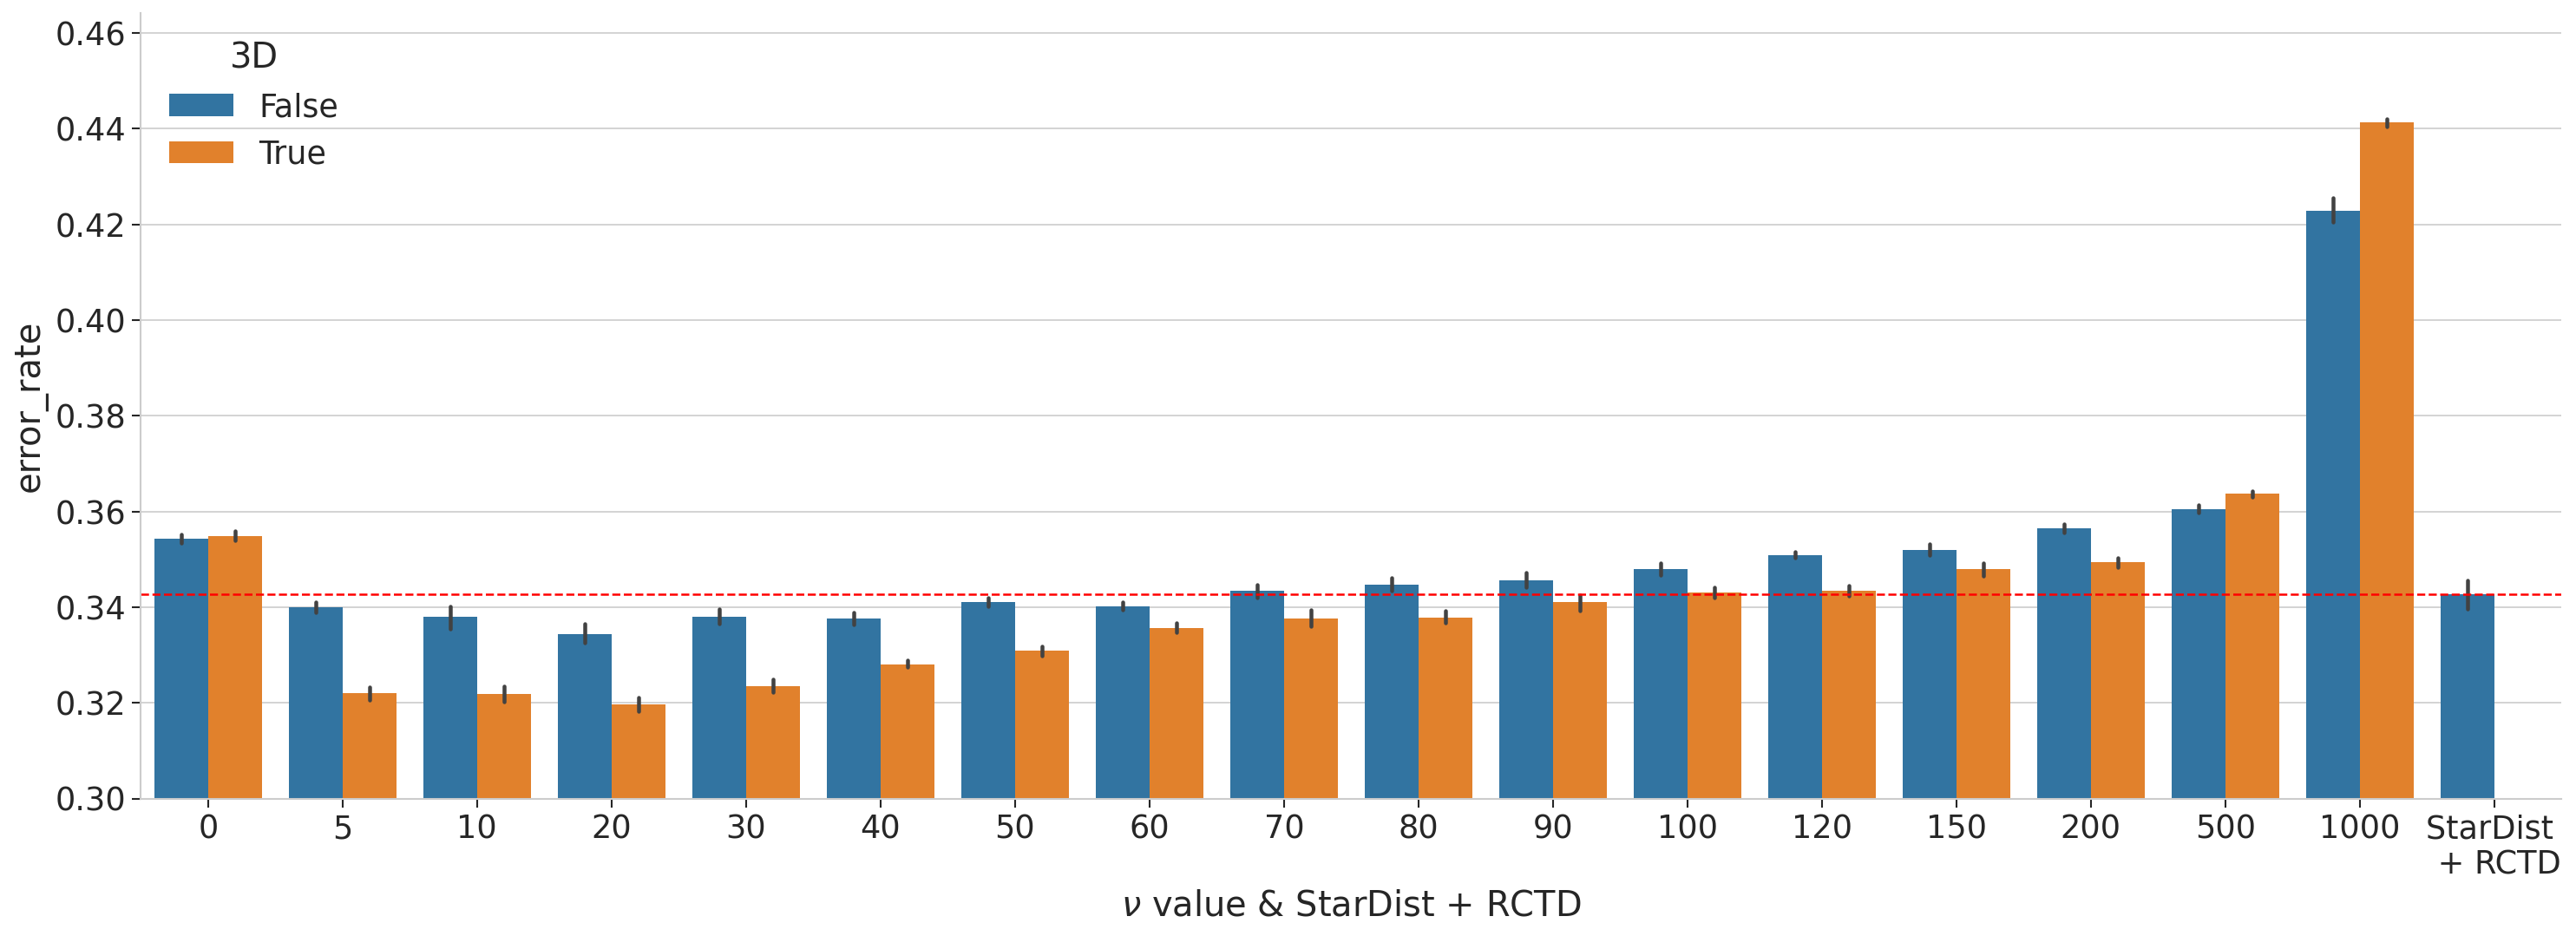

In [294]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (24, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",hue = '3D',data=error_rate_df, palette="tab10", ax = ax)
ax.set_ylim(0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

## deconvolution


In [21]:
temp = decon_df.copy()
temp = temp[temp.nu != 1e-6]
temp['nu'] = temp['nu'].astype(int)

vis_decon_df = pd.DataFrame()
vis_decon_df['value'] = temp.RCTD.tolist() + temp.SR.tolist() + temp.SpatialScope.tolist() + temp.SpatialScope_3D.tolist()
vis_decon_df['method'] = ['RCTD'] * temp.shape[0] + ['StarDist+RCTD'] * temp.shape[0] + ['SpatialScope'] * temp.shape[0] + ['SpatialScope_3D'] * temp.shape[0]
vis_decon_df['nu'] = temp.nu.tolist() * 4
vis_decon_df['metric'] = temp.metric.tolist() * 4

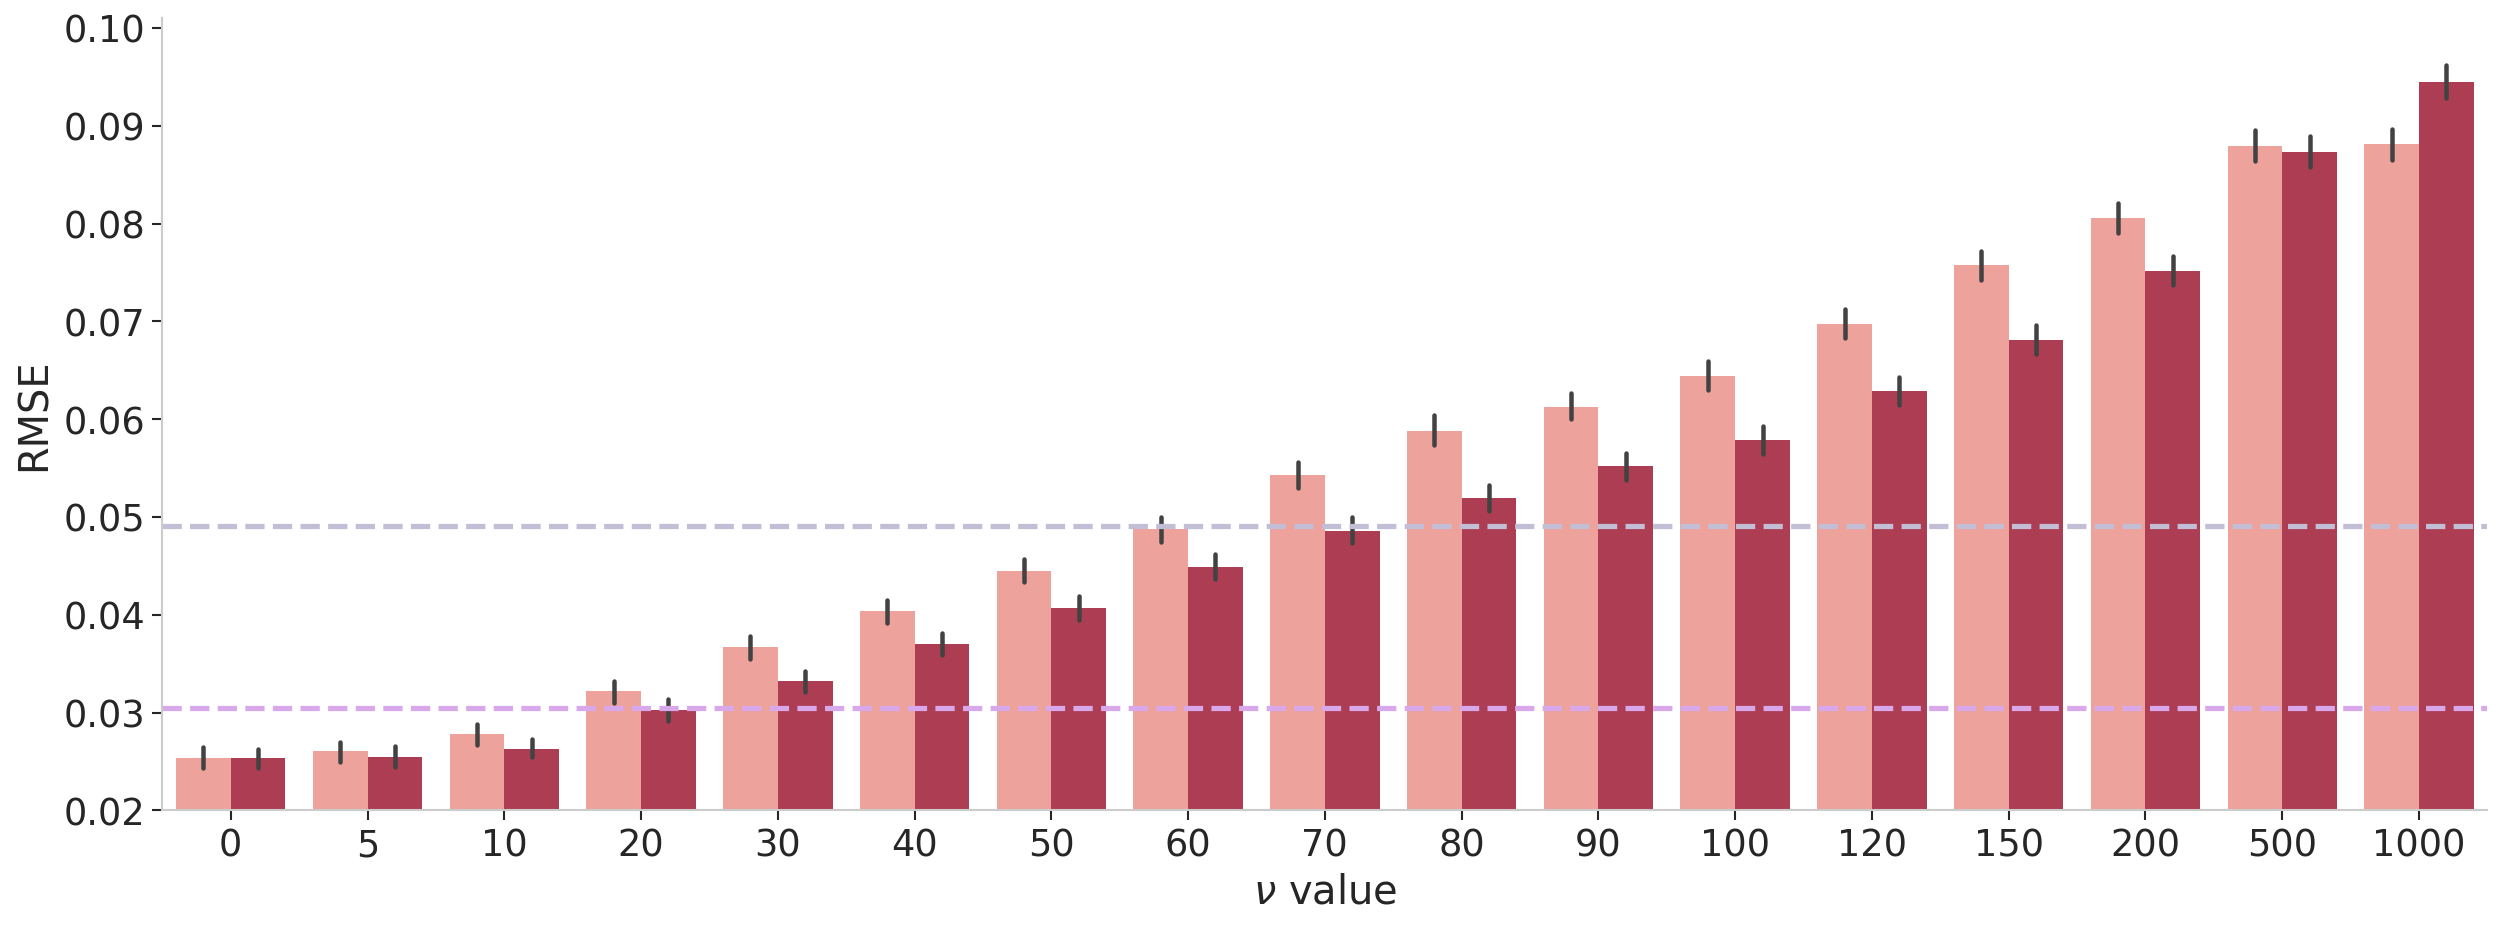

In [35]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'rmse')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value", hue = 'method', data=vis_decon_df[(vis_decon_df.metric == 'rmse') & (vis_decon_df['method'].isin(['SpatialScope', 'SpatialScope_3D']))], width = 0.8, palette=['#FB988E', '#C02A47'], ax = ax)
ax.set_ylim(0.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
ax.legend_.remove()
ax.grid(False)
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

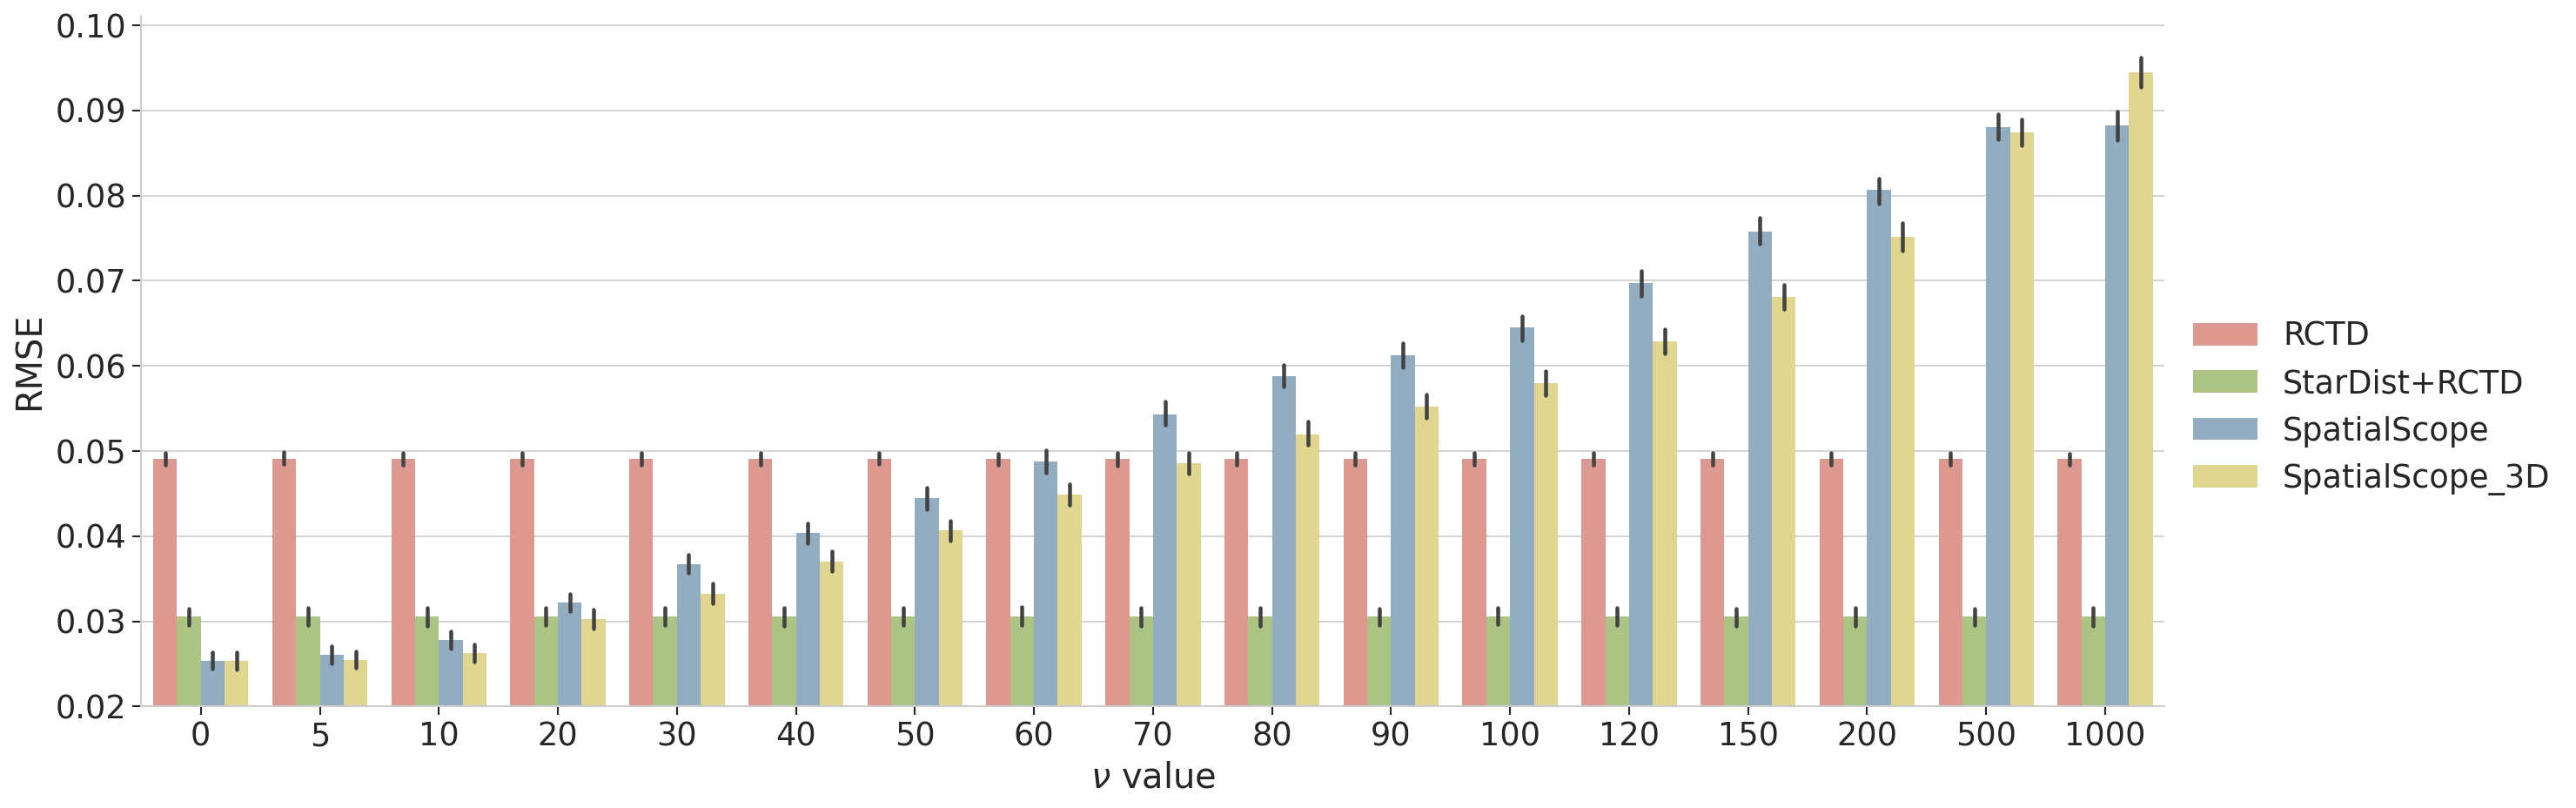

In [301]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'rmse'], palette=['#EA8E83', '#AFCF78', '#8AAEC9', '#EDE081'], ax = ax)
ax.set_ylim(0.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
# ax.set_xticklabels(vis_nu_list[:-1])

plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

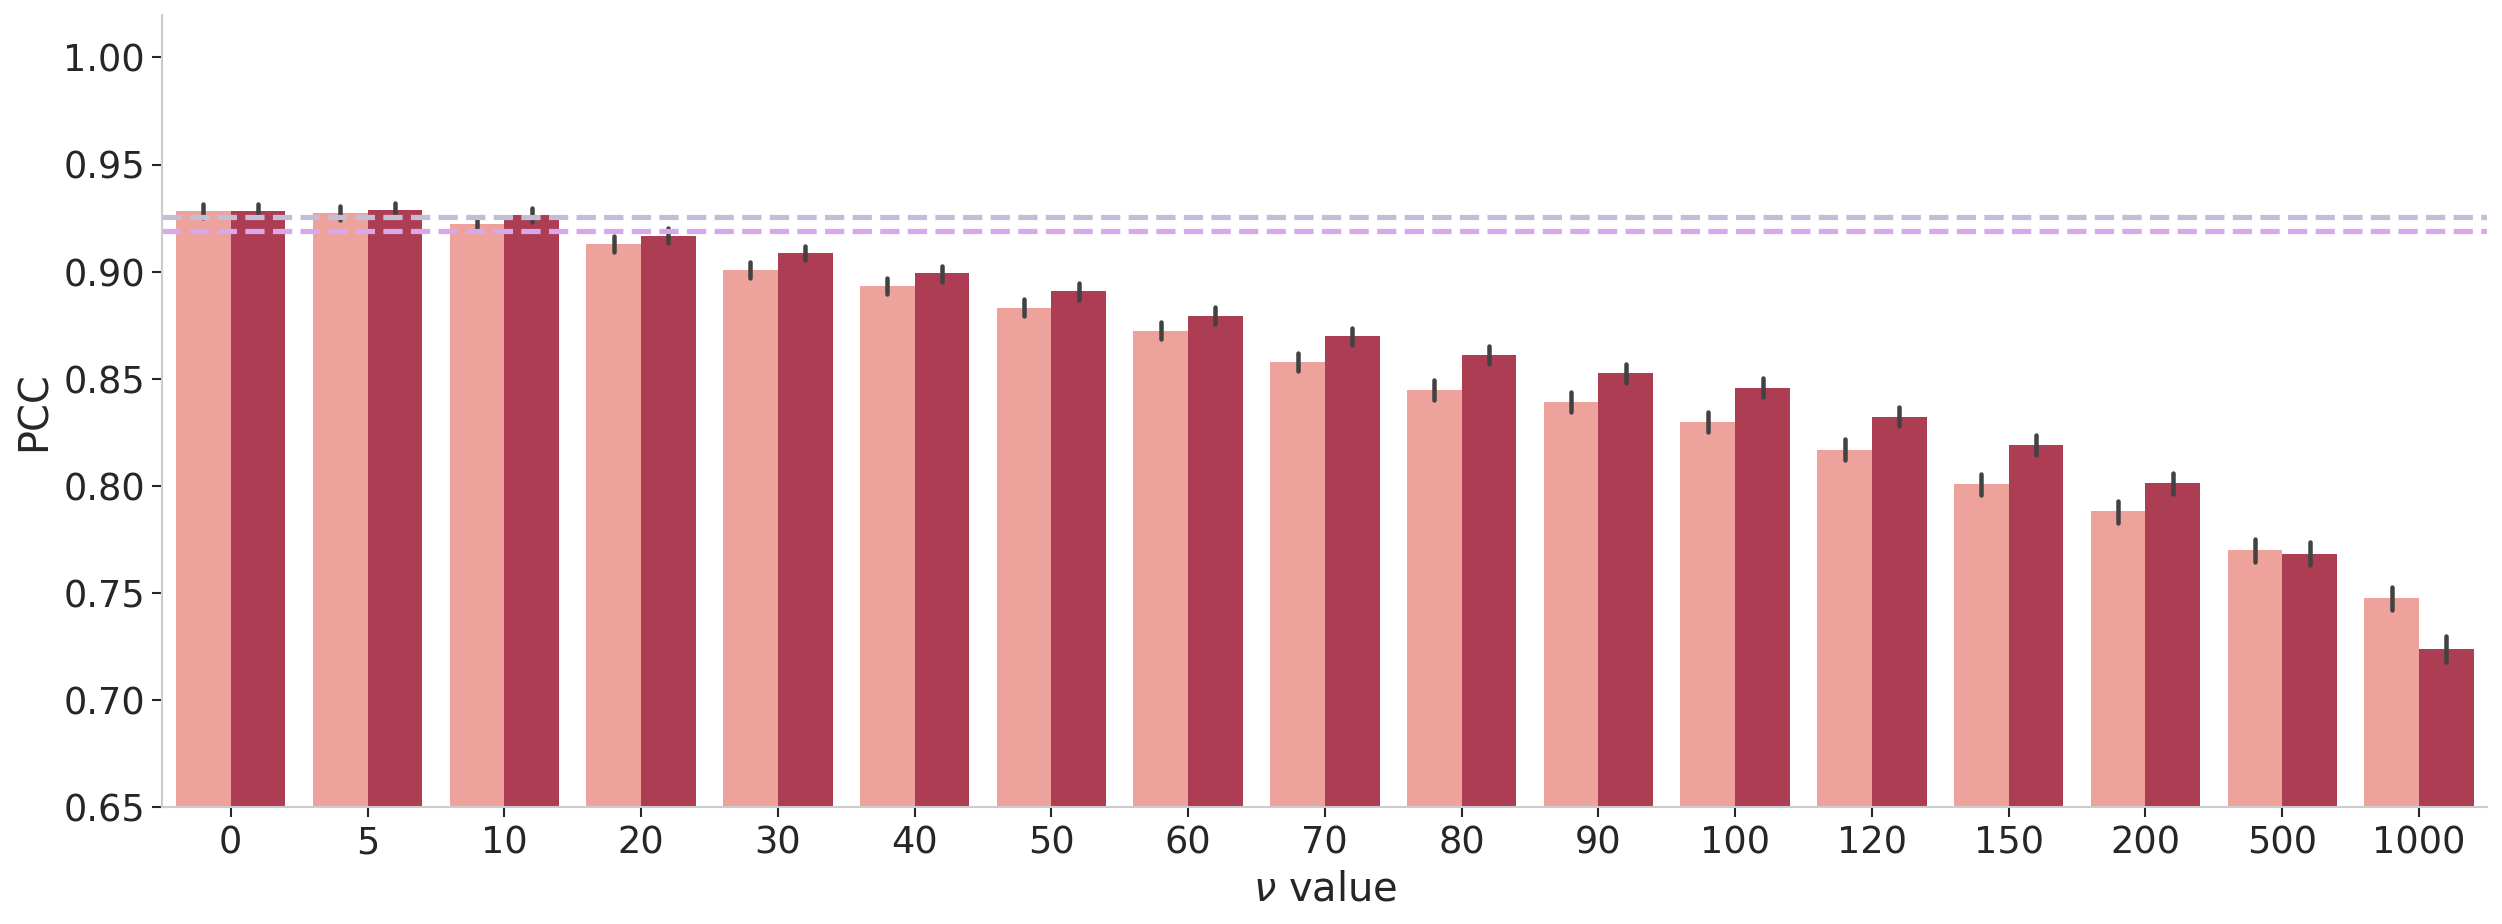

In [36]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'pcc')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value", hue = 'method', data=vis_decon_df[(vis_decon_df.metric == 'pcc') & (vis_decon_df['method'].isin(['SpatialScope', 'SpatialScope_3D']))], width = 0.8, palette=['#FB988E', '#C02A47'], ax = ax)
ax.set_ylim(0.65,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
ax.legend_.remove()
ax.grid(False)
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

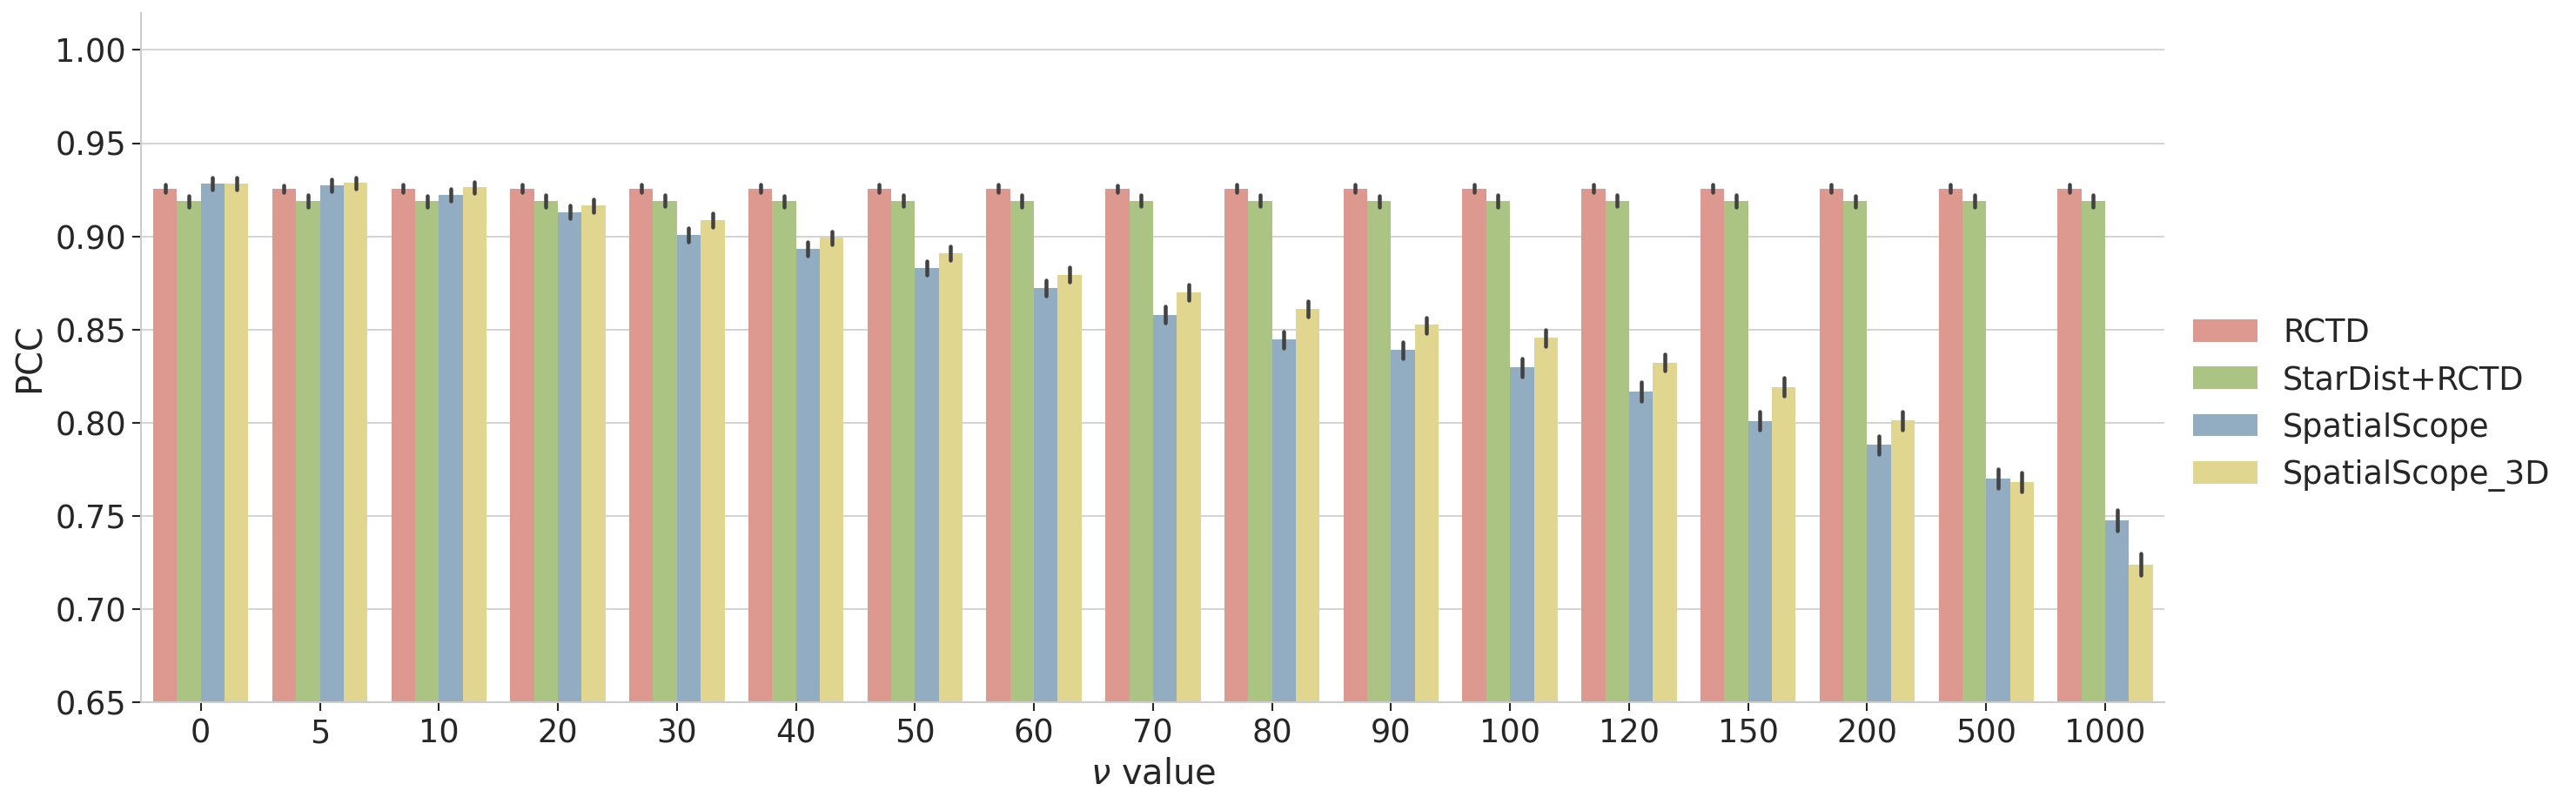

In [302]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'pcc'], palette=['#EA8E83', '#AFCF78', '#8AAEC9', '#EDE081'], ax = ax)
ax.set_ylim(0.65,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

## example results

In [303]:
DataDir

'/home/share/xwanaf/sour_sep/revision/data/RCTD_MOp_3D/15x45/265UMI'

In [331]:
nu = 10
cell_locations = pd.read_csv(os.path.join(DataDir, '3D_single', neighbor_range, 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)
cell_locations_3D = pd.read_csv(os.path.join(DataDir, neighbor_range, 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

SR_results = sc.read(os.path.join(DataDir, neighbor_range, 'rep' + str(0), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
SR_cell_type_label = SR_results.uns['cell_locations'].copy()

## ground truth

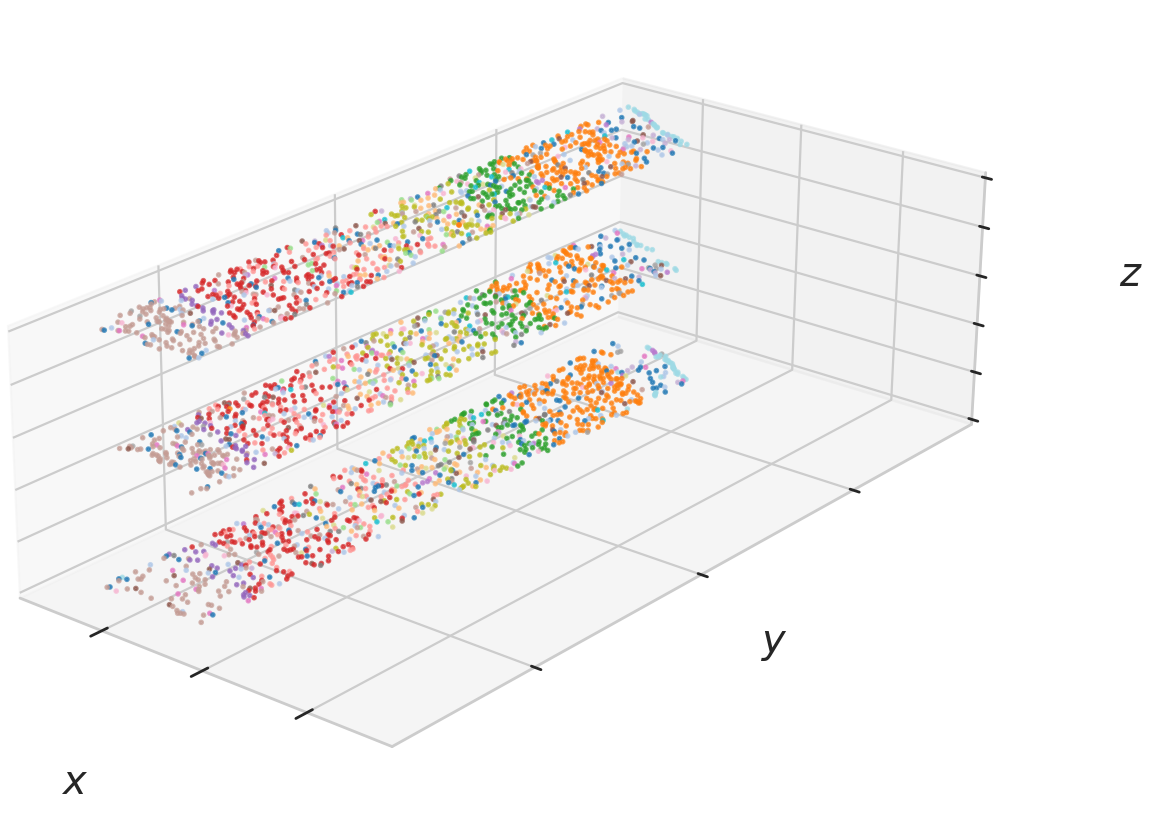

In [332]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z']) * 50 / 3


sns.set_context('paper',font_scale=1.5)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

ax.scatter(x, y, z, c=cell_locations_3D[sp_cell_class_column].map(color_dict), s=1.5, alpha=0.7)
ax.set_zlim(0,100)
ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])


plt.gca().invert_yaxis()
ax.view_init(23,130)
plt.show()

## SpatialScope

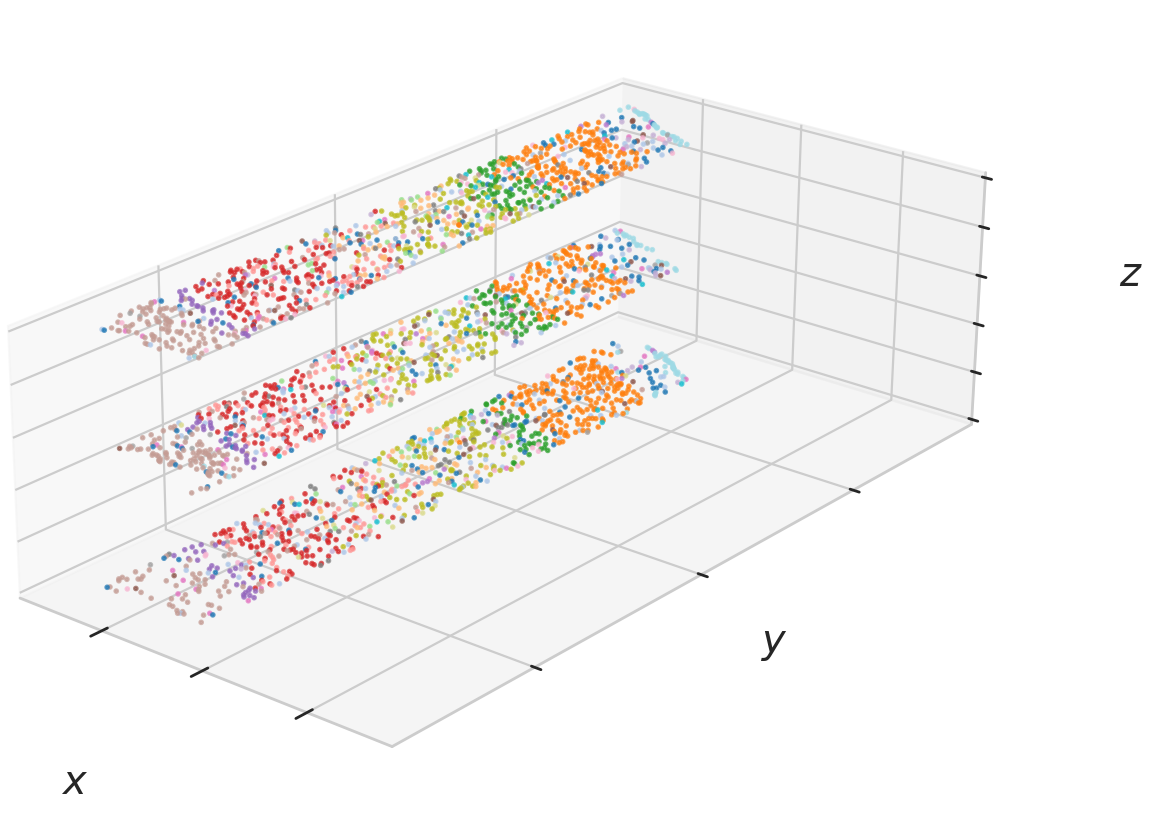

In [333]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z']) * 50 / 3


sns.set_context('paper',font_scale=1.5)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

ax.scatter(x, y, z, c=cell_locations['discrete_label_ct'].map(color_dict), s=1.5, alpha=0.7)
ax.set_zlim(0,100)
ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

plt.gca().invert_yaxis()
ax.view_init(23,130)
plt.show()

# SpatialScope 3D

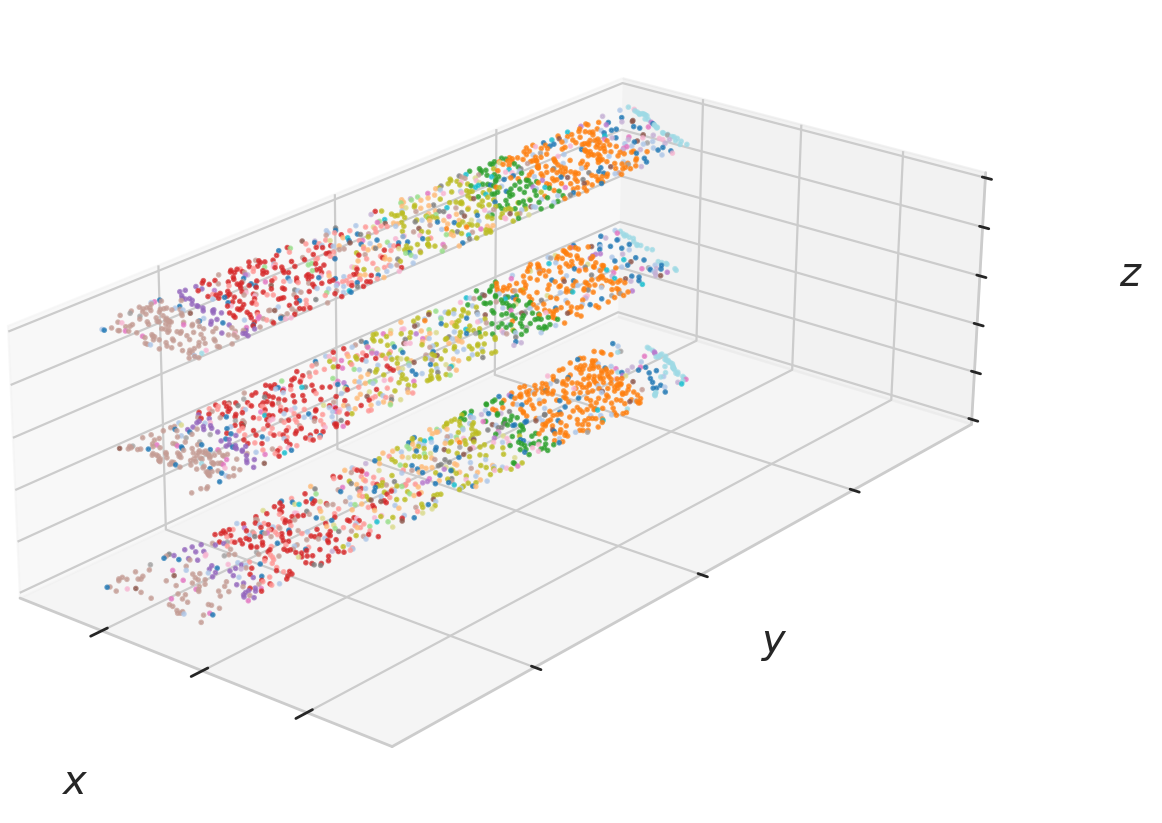

In [334]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z']) * 50 / 3


sns.set_context('paper',font_scale=1.5)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

ax.scatter(x, y, z, c=cell_locations_3D['discrete_label_ct'].map(color_dict), s=1.5, alpha=0.7)
ax.set_zlim(0,100)
ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

plt.gca().invert_yaxis()
ax.view_init(23,130)
plt.show()

### StarDist + RCTD 

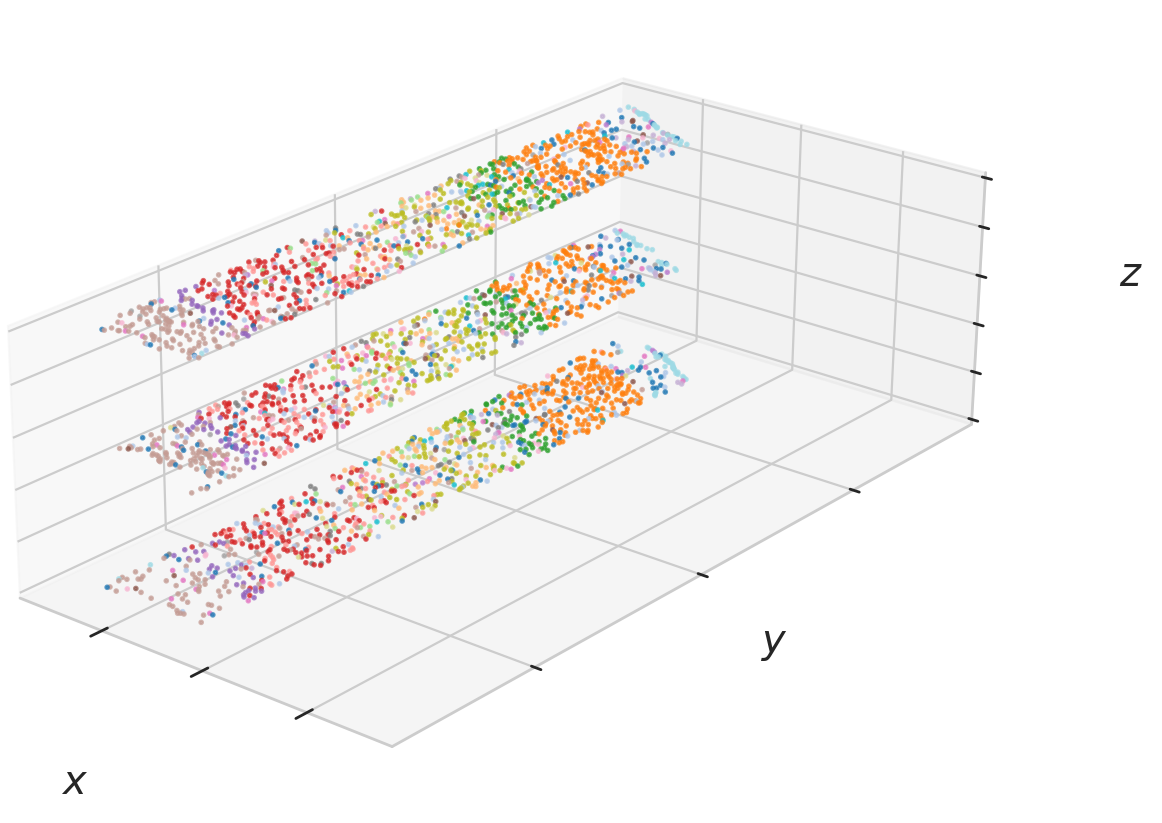

In [335]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x,y,z = np.array(cell_locations_3D['x']), \
            np.array(cell_locations_3D['y']), \
            np.array(cell_locations_3D['z']) * 50 / 3


sns.set_context('paper',font_scale=1.5)
# plt.figure(figsize=(15, 5),dpi = 150)
# ax = plt.subplot(1,3,(1,2), projection='3d')
# ax1 = plt.subplot(1,3,3)

fig = plt.figure(figsize=(10,5),dpi=200)
ax = fig.gca(projection='3d')# fig.add_subplot(projection='3d')


ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1., 2, 0.8, 1]))

# ax.scatter(x1, y1, z1, c=ad_sp1.obs['subclass'].map(color_dict), s=1.5, alpha=1)
# ax.scatter(x2, y2, z2, c=ad_sp2.obs['subclass'].map(color_dict), s=1.5, alpha=1)

ax.scatter(x, y, z, c=SR_cell_type_label['SDRCTD_cell_type'].map(color_dict), s=1.5, alpha=0.7)
ax.set_zlim(0,100)
ax.set_xlim(-1800,-500)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.zaxis.set_ticklabels([])

plt.gca().invert_yaxis()
ax.view_init(23,130)
plt.show()